# 데이터 살펴보기

In [1]:
# 필요한 라이브러리
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import shapiro

# 데이터 불러오기
raw_file = 'accepted_2007_to_2018Q4.csv'
sumin_file = 'accepted_2007_to_2018Q4 2.csv'
cleaned_file = 'acc_cleaned.csv'
acc_file = 'acc.csv'
acc = pd.read_csv(acc_file)

print(acc.shape)
acc.head()

(1345350, 24)


,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_util,total_acc,loan_status,pub_rec,pub_rec_bankruptcies,mort_acc,inq_last_6mths,inq_last_12m,num_bc_tl,num_actv_bc_tl
0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,...,29.7,13.0,0,0.0,0.0,1.0,1.0,4.0,5.0,2.0
1,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,...,19.2,38.0,0,0.0,0.0,4.0,4.0,6.0,17.0,5.0
2,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,...,56.2,18.0,0,0.0,0.0,5.0,0.0,1.0,4.0,2.0
3,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,...,64.5,35.0,0,0.0,0.0,6.0,3.0,3.0,9.0,4.0
4,11950.0,36 months,13.44,405.18,C,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,...,68.4,6.0,0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


In [2]:
# # 대출상환 항목 3개만 남기기
# ## acc = 대출상환목록 3개로 정리
# acc= acc[acc['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])].copy()

In [3]:
# # 대출상환 항목 0,1로 인코딩
# status_map = {
#     'Fully Paid': 0,
#     'Charged Off': 1,
#     'Default': 1
# }
# acc['loan_status'] = acc['loan_status'].map(status_map)

In [4]:
# # null 값이 80% 이상인 컬럼 삭제
# ## acc = 대출상환목록 3개로 정리, Null 값이 80% 이상인 컬럼 삭제

# threshold = acc.shape[0] * 0.8               # 기준 만들고
# cols_to_drop = acc.columns[acc.isnull().sum() > threshold]  # 조건에 맞는 컬럼 추출
# acc = acc.drop(columns=cols_to_drop)          # 해당 컬럼 삭제

In [5]:
# # 논문 참고하여 칼럼 셀렉
# ## acc = 대출상환목록 3개로 정리, 
# #        Null 값이 80% 이상인 컬럼 삭제,
# #        중요 칼럼만 남김,

# columns_to_keep = [
#     'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
#     'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
#     'verification_status', 'purpose', 'dti', 'open_acc', 'revol_bal',
#     'revol_util', 'total_acc', 'loan_status', 'pub_rec',
#     'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths',
#     'inq_last_12m', 'num_bc_tl', 'num_actv_bc_tl'
# ]

# acc = acc[columns_to_keep]

In [6]:
# # 숫자형
# acc.select_dtypes(include='number').columns

# # 범주형
# acc.select_dtypes(exclude='number').columns

## 데이터 분포 살펴보기

In [7]:
# na 제외한 문자열 소문자 변환 + 앞뒤 공백제거
acc['emp_title'] = acc['emp_title'].apply(
    lambda x: x.lower().strip() if pd.notnull(x) else x
)

In [8]:
# inq_last_12m 칼럼 삭제

acc = acc.drop('inq_last_12m' , axis = 1)

### loan_amnt , int_rate , installment 데이터 분포

loan_amnt skewness: 0.7824983744130591
int_rate skewness: 0.7134897274225662
installment skewness: 1.006541533525739


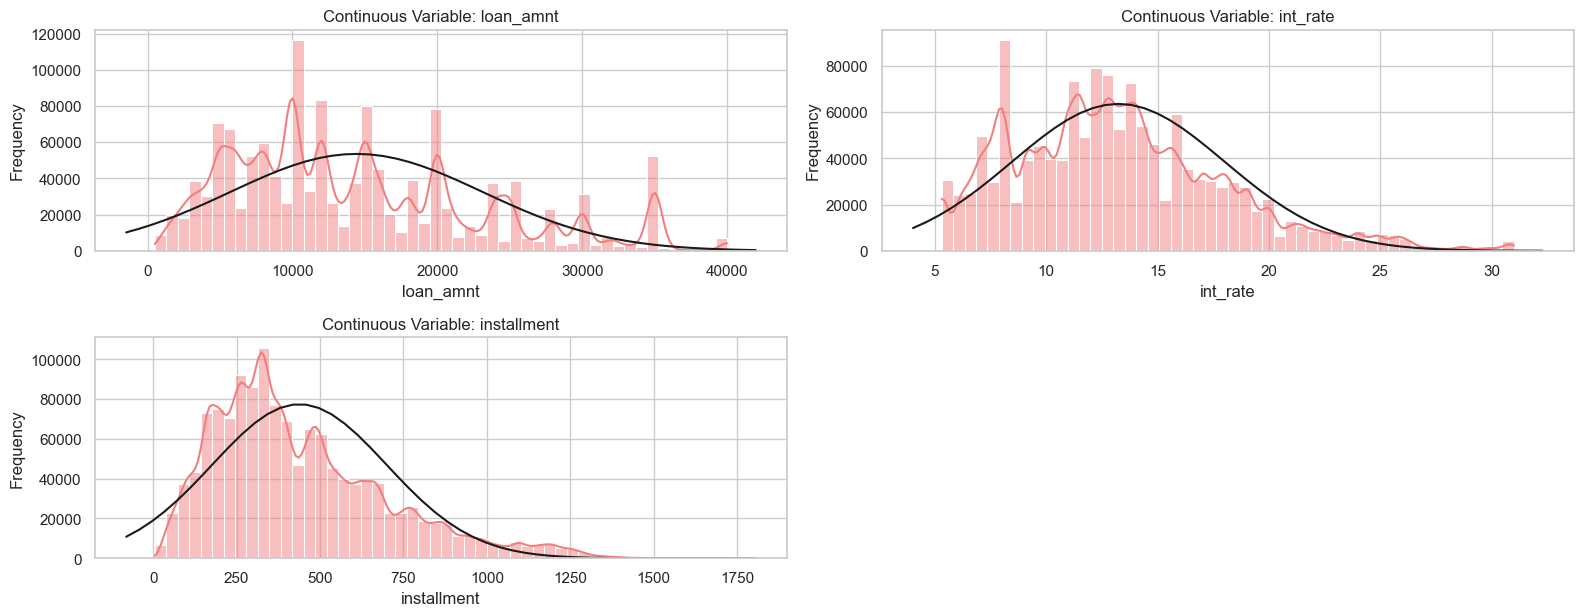

In [9]:
# 로그 변환 전
# 변수 분류
categorical_vars = acc.iloc[:, :6].select_dtypes(include='object').columns.to_list()
continuous_vars = acc.iloc[:, :6].select_dtypes(exclude='object').columns.to_list()

# 시각화 스타일
sns.set_theme(style="whitegrid") # set -> set_theme
plt.figure(figsize=(16, 12))

for i, var in enumerate(continuous_vars):
    plt.subplot(4, 2, i + 1)
    # 데이터 분포 히스토그램
    sns.histplot(acc[var], kde=True, color='lightcoral', bins=50)

    # 왜도 출력
    print(f'{var} skewness:', stats.skew(acc[var]))

    # 정규분포 곡선 추가 (히스토그램 기준에 맞게 스케일링)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 50)
    mean = acc[var].mean()
    std = acc[var].std()
    pdf = stats.norm.pdf(x, mean, std)
    
    bin_width = (xmax - xmin) / 50
    pdf_scaled = pdf * len(acc[var]) * bin_width  # 스케일 조정

    plt.plot(x, pdf_scaled, 'k', linewidth=1.5)
    plt.title(f'Continuous Variable: {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
# 저장 코드
# plt.savefig('image/histogram_0~5_cn.png', dpi=150)
plt.show()

In [10]:
# 정규성 가정 확인
for var in continuous_vars:
    stat, pvalue = stats.shapiro(acc[var])
    t = '기각' if pvalue < 0.05 else '귀무가설 채택'
    print(f'{var} shapiro: stats - {stat} pvalue - {pvalue} 기각여부 - {t}')

loan_amnt shapiro: stats - 0.9373830223556792 pvalue - 1.436527800123502e-142 기각여부 - 기각
int_rate shapiro: stats - 0.9650089558067869 pvalue - 6.558833644755773e-125 기각여부 - 기각
installment shapiro: stats - 0.930280067502587 pvalue - 5.8506684600576e-146 기각여부 - 기각


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


왜도가 보통 +1 이상이면 우측 긴꼬리, -1 이하이면 좌측 긴꼬리, -0.5~0.5는 대체로 대칭이라고 봄.

정규성 가정도 해봤을 때 정규성이 없음 

=> log 변환 필요!, na 처리는 따로 할 필요 없음

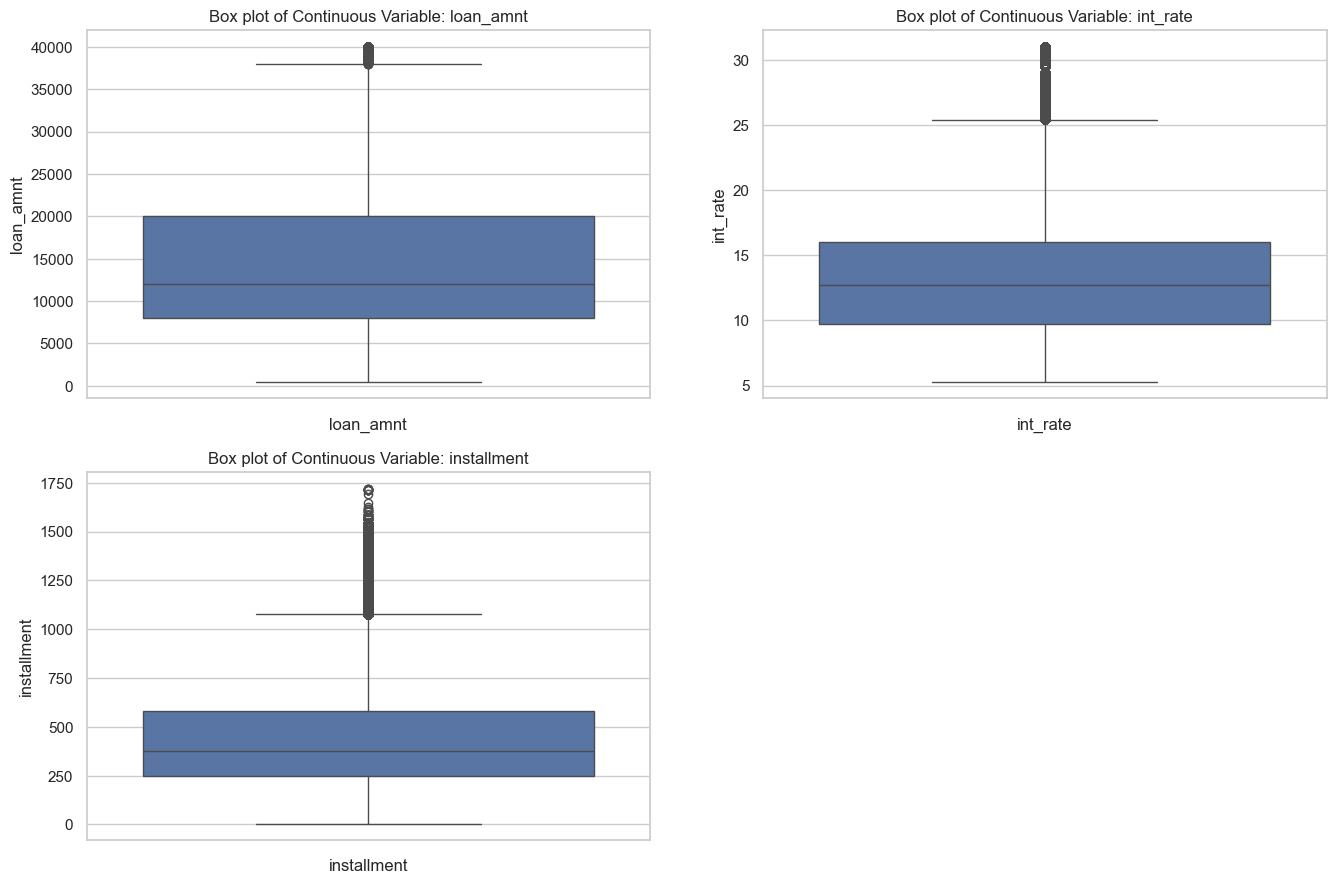

In [11]:
# 박스 플랏도 한 번 살펴보기
plt.figure(figsize=(16, 22))
for i, var in enumerate(continuous_vars):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(acc[var])
    plt.title(f'Box plot of Continuous Variable: {var}')
    plt.xlabel(var)

# 저장 코드
# plt.savefig('image/boxplot_sehee_cn.png', dpi=150)
plt.show()

In [12]:
acc_log = acc.copy()

loan_amnt skewness: -0.6534344754315877
int_rate skewness: -0.19304481097929954
installment skewness: -0.6076505222384652


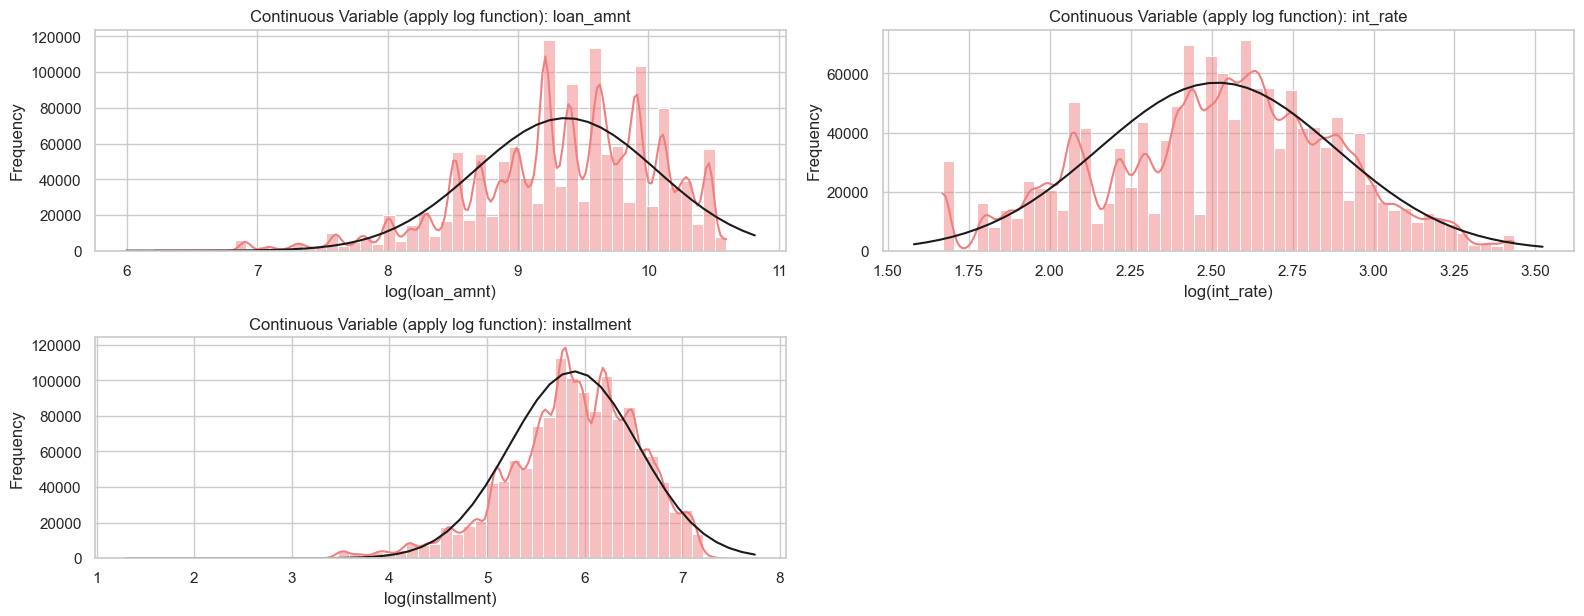

In [13]:
## 로그 변환 적용
# 시각화 스타일
sns.set_theme(style="whitegrid") # set -> set_theme
plt.figure(figsize=(16, 12))

for i, var in enumerate(continuous_vars):
    acc_log[var] = np.log(acc_log[var])  # 0값이 없는 칼럼들이기에 

    plt.subplot(4, 2, i + 1)
    # 데이터 분포 히스토그램
    sns.histplot(acc_log[var], kde=True, color='lightcoral', bins=50)

    # 왜도 출력
    print(f'{var} skewness:', stats.skew(acc_log[var]))

    # 정규분포 곡선 추가 (히스토그램 기준에 맞게 스케일링)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 50)
    mean = acc_log[var].mean()
    std = acc_log[var].std()
    pdf = stats.norm.pdf(x, mean, std)
    
    bin_width = (xmax - xmin) / 50
    pdf_scaled = pdf * len(acc_log[var]) * bin_width  # 스케일 조정

    plt.plot(x, pdf_scaled, 'k', linewidth=1.5)
    plt.title(f'Continuous Variable (apply log function): {var}')
    plt.xlabel(f'log({var})')
    plt.ylabel('Frequency')

plt.tight_layout()
# 저장 코드
# plt.savefig('image/histogram_log_sehee_cn.png', dpi=150)
plt.show()


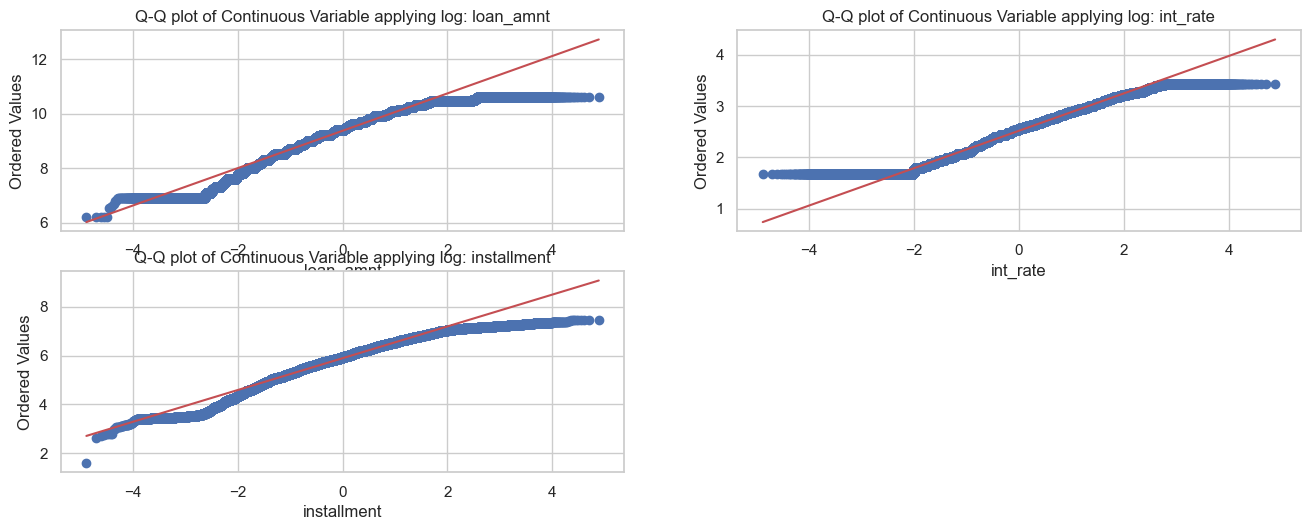

In [14]:
# Q-Q plot
plt.figure(figsize=(16, 12))
for i, var in enumerate(continuous_vars):
    plt.subplot(4, 2, i + 1)
    stats.probplot(acc_log[var], dist='norm', plot=plt)
    plt.title(f'Q-Q plot of Continuous Variable applying log: {var}')
    plt.xlabel(var)

# 그래프 사진으로 저장
# plt.savefig('image/Q-Qplot_log_sehee.png', dpi=150)
plt.show()

### term , grade

/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_28507/1608472292.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=acc_log, ax=axes[i],  palette='pastel')
/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_28507/1608472292.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=acc_log, ax=axes[i],  palette='pastel')


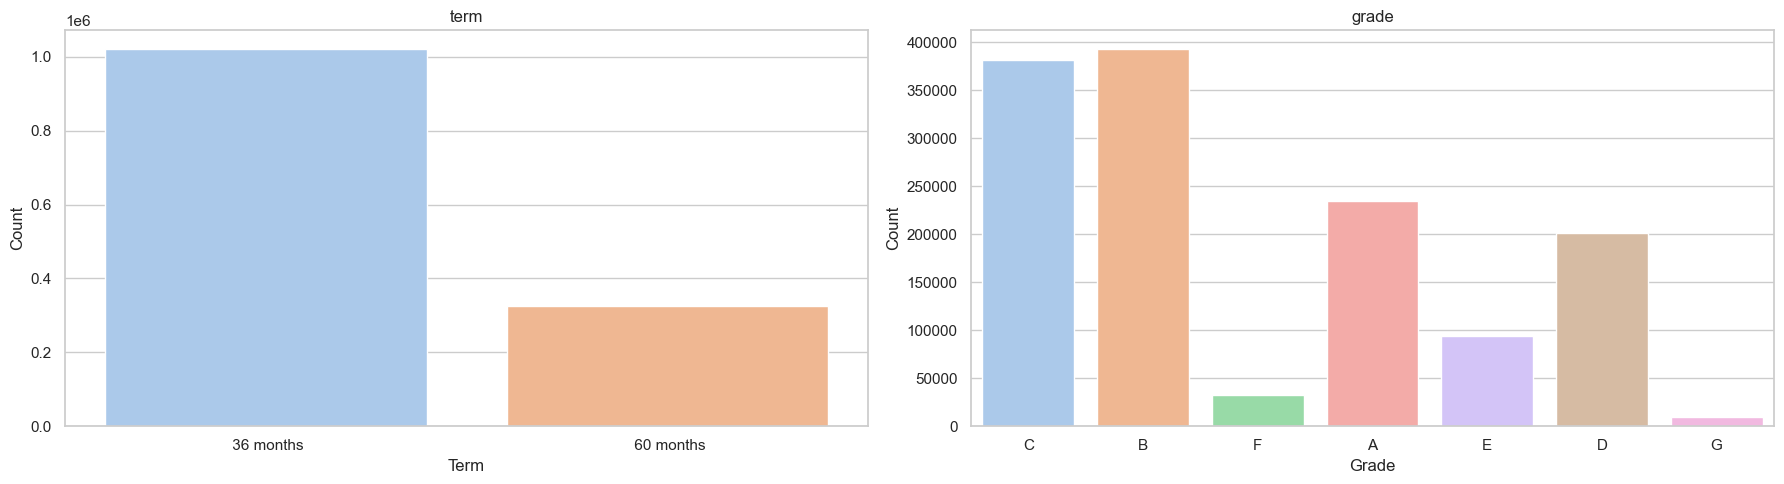

In [15]:
# 시각화 설정
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1행 3열

# 반복문으로 subplot에 countplot 그리기
for i, col in enumerate(categorical_vars[:2]):
    sns.countplot(x=col, data=acc_log, ax=axes[i],  palette='pastel')
    axes[i].set_title(categorical_vars[i])
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Count')

plt.tight_layout()
# 그래프 사진으로 저장
# plt.savefig('image/countplot_sehee_ct.png', dpi=150)
plt.show()

### emp_title

In [16]:
# 직업 unique 값 따로 살펴보기
emp_count = pd.DataFrame(acc_log.value_counts(['emp_title']).reset_index())
emp_count.head()

,emp_title,count
0,teacher,26733
1,manager,26232
2,owner,16171
3,registered nurse,12947
4,supervisor,12715


In [17]:
emp_count['count'].agg({'mean', 'median'})

mean      4.063723
median    1.000000
Name: count, dtype: float64

In [18]:
print('10 사람 이상인 직업 비율 : ', emp_count[emp_count['count'] >= 10].shape[0] /  emp_count.shape[0])
print('한 사람밖에 없는 직업 비율 : ', emp_count[emp_count['count'] == 1].shape[0] / emp_count.shape[0])

10 사람 이상인 직업 비율 :  0.030072398306834607
한 사람밖에 없는 직업 비율 :  0.7806273229403262


In [19]:
# 운영체제 확인
system_name = platform.system()

# OS별 폰트 설정
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우용
elif system_name == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif system_name == 'Linux':
    plt.rc('font', family='NanumGothic')  # 설치 필요할 수도 있음
else:
    print(f"Unknown OS: {system_name}. Set font manually if needed.")


# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

### dti , annual_inc


===== 수치형 변수: dti =====
결측치 수: 374개, 전체: 1345350개, 결측치 비율: 0.0278%


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


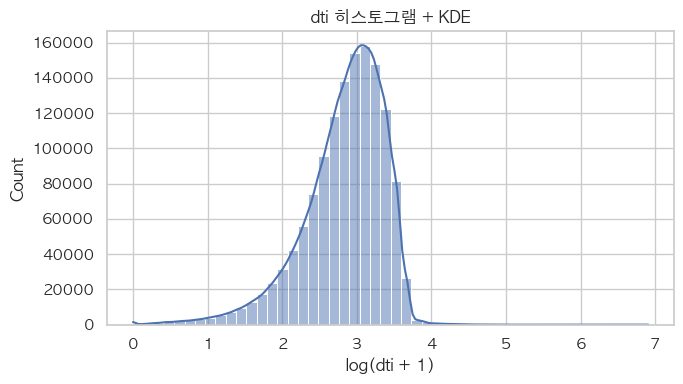

/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2913: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())


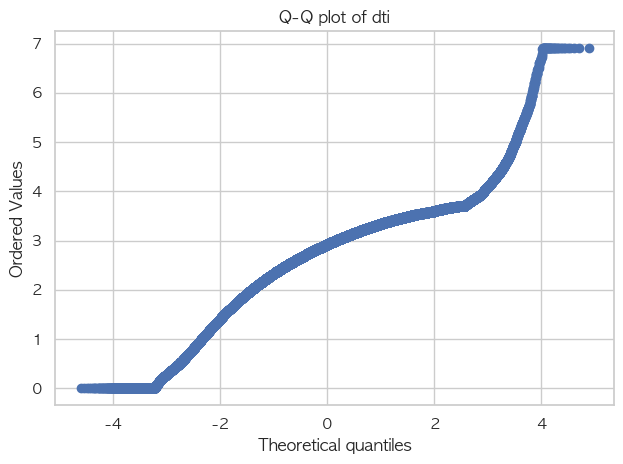

Shapiro-Wilk 검정 p-value: 0.0000
→ 정규성을 따르지 않음

===== 수치형 변수: annual_inc =====
결측치 수: 0개, 전체: 1345350개, 결측치 비율: 0.0000%


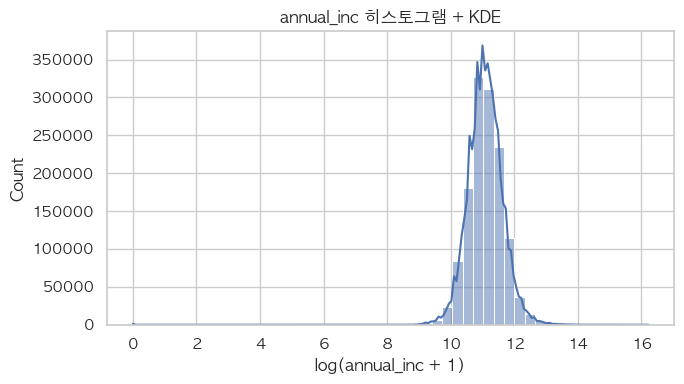

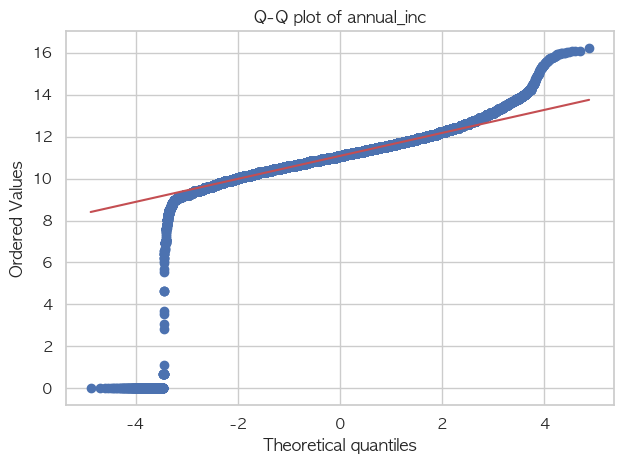

Shapiro-Wilk 검정 p-value: 0.0000
→ 정규성을 따르지 않음


In [20]:

# [1] 수치형 변수 결측치 확인 및 로그 변환 + 정규성 검정 (dti, annual_inc)
num_cols = ['dti', 'annual_inc']

for col in num_cols:
    print(f"\n===== 수치형 변수: {col} =====")
    
    # 결측치 확인
    missing_count = acc_log[col].isnull().sum()
    total_count = acc_log.shape[0]
    missing_ratio = missing_count / total_count * 100
    print(f"결측치 수: {missing_count}개, 전체: {total_count}개, 결측치 비율: {missing_ratio:.4f}%")
    
    # 로그 변환: log(1+x)로 0 처리
    acc_log[f'{col}'] = np.log1p(acc_log[col])

    # 히스토그램 + KDE (로그 변환된 데이터)
    plt.figure(figsize=(7, 4))
    sns.histplot(acc_log[f'{col}'].dropna(), bins=50, kde=True)
    plt.title(f'{col} 히스토그램 + KDE')
    plt.xlabel(f'log({col} + 1)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    

    # Q-Q plot (원본 데이터 사용)
    stats.probplot(acc_log[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {col}")
    plt.tight_layout()
    plt.show()

    # Shapiro-Wilk 정규성 검정 (최대 5000 샘플링)
    sample = acc_log[col].dropna()
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    stat, p = shapiro(sample)
    print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")
    if p < 0.05:
        print("→ 정규성을 따르지 않음")
    else:
        print("→ 정규성을 만족함")

### open_acc

In [21]:
# 1. open_acc 개설된 신용 계좌수 p-value

stat, p = shapiro(acc_log['open_acc'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


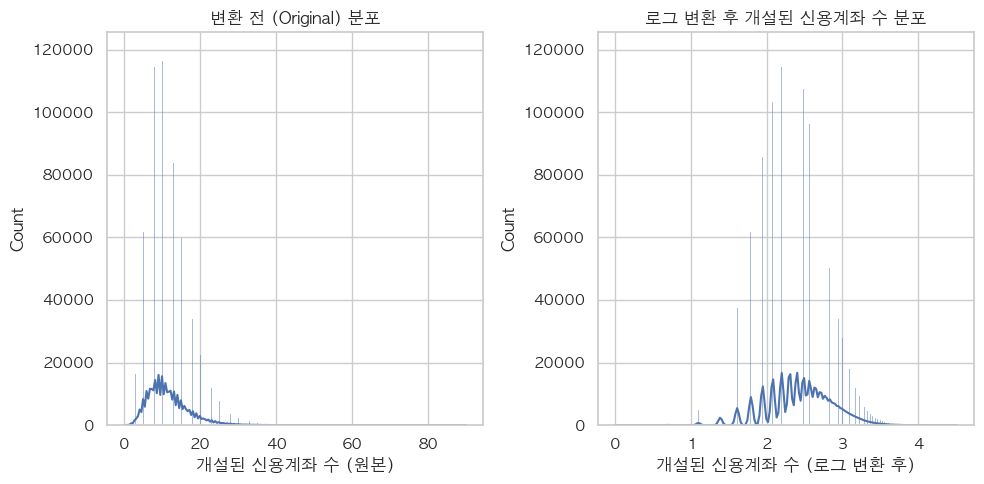

In [22]:
# 로그 변환 적용
acc_log['open_acc'] = np.log1p(acc_log['open_acc'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc['open_acc'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel('개설된 신용계좌 수 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['open_acc'], kde=True)
plt.title('로그 변환 후 개설된 신용계좌 수 분포')
plt.xlabel('개설된 신용계좌 수 (로그 변환 후)')

plt.tight_layout()
plt.show()

### revol_bal

In [23]:
# 2. revol_bal 리볼빙 대출 잔액 p-value
stat, p = shapiro(acc['revol_bal'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


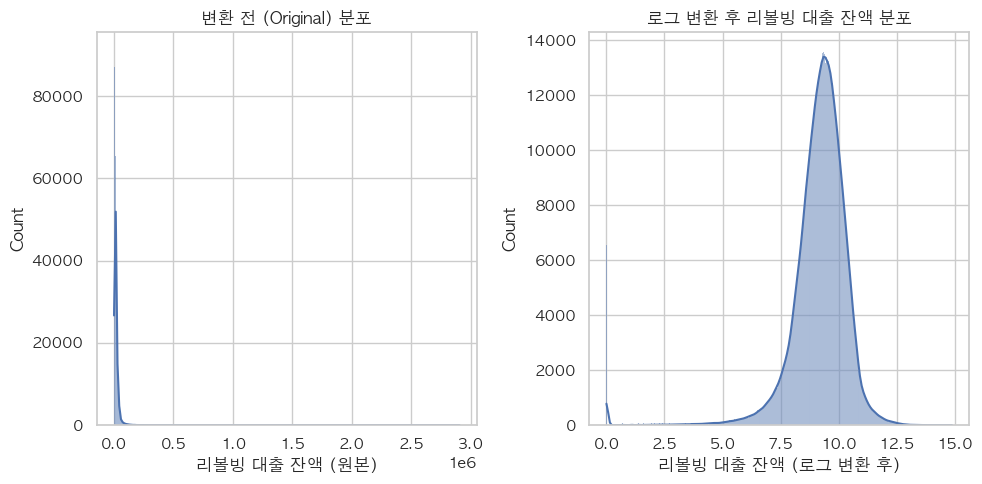

In [24]:
# 로그 변환 적용
acc_log['revol_bal'] = np.log1p(acc_log['revol_bal'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc['revol_bal'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel('리볼빙 대출 잔액 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['revol_bal'], kde=True)
plt.title('로그 변환 후 리볼빙 대출 잔액 분포')
plt.xlabel('리볼빙 대출 잔액 (로그 변환 후)')

plt.tight_layout()
plt.show()

### revol_util

In [25]:
# 3. revol_util 리볼빙 대출 사용률 p-value

stat, p = shapiro(acc['revol_util'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1344493.
  res = hypotest_fun_out(*samples, **kwds)


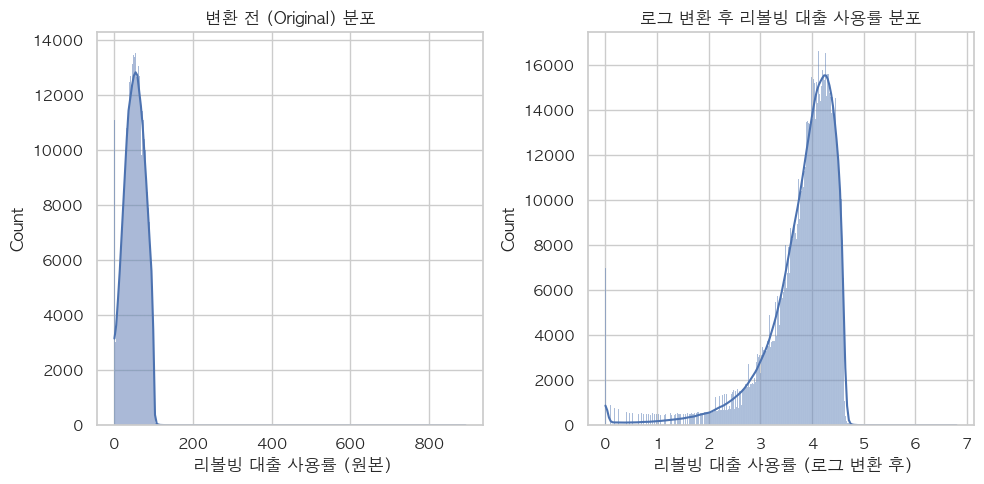

In [26]:
# 로그 변환 적용
acc_log['revol_util'] = np.log1p(acc_log['revol_util'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc['revol_util'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 리볼빙 대출 사용률 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['revol_util'], kde=True)
plt.title('로그 변환 후 리볼빙 대출 사용률 분포')
plt.xlabel(' 리볼빙 대출 사용률 (로그 변환 후)')

plt.tight_layout()
plt.show()

### total_acc

In [27]:
# 4. total_acc 전체 신용계좌 수 p-value

stat, p = shapiro(acc['total_acc'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


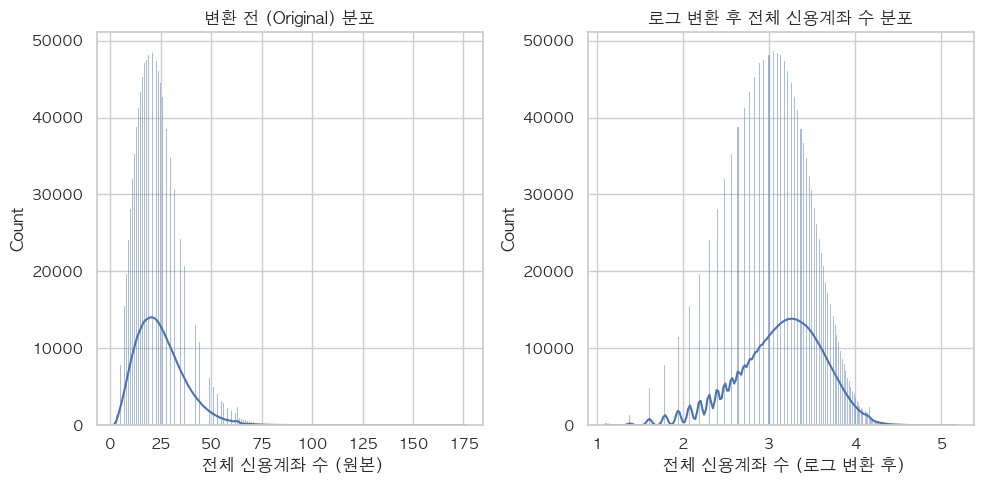

In [28]:
# 로그 변환 적용
acc_log['total_acc'] = np.log1p(acc_log['total_acc'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc['total_acc'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 전체 신용계좌 수 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['total_acc'], kde=True)
plt.title('로그 변환 후 전체 신용계좌 수 분포')
plt.xlabel(' 전체 신용계좌 수 (로그 변환 후)')

plt.tight_layout()
plt.show()

### loan_status

In [29]:
# 5. loan_status 대출 상태 p-value
stat, p = shapiro(acc['loan_status'])

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


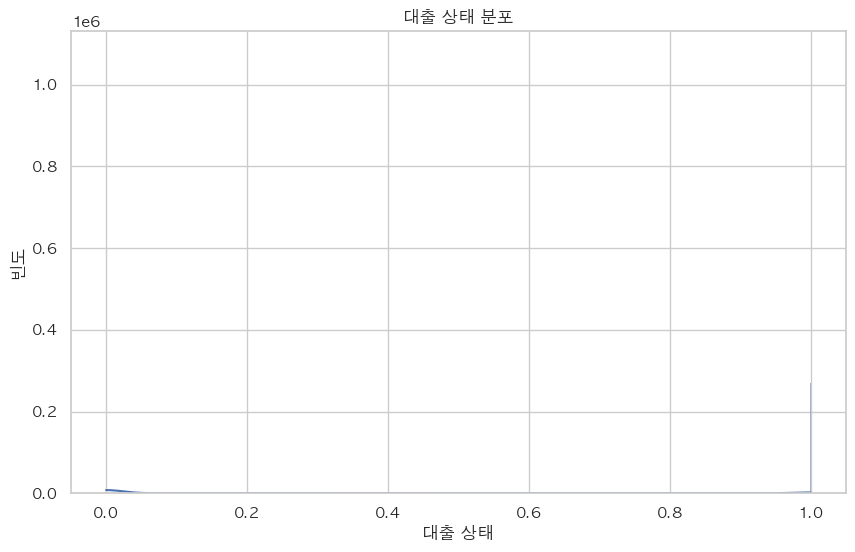

In [30]:
# loan_status 대출 상태
plt.figure(figsize=(10, 6))
sns.histplot(acc['loan_status'], kde=True)
plt.title('대출 상태 분포')
plt.xlabel('대출 상태')
plt.ylabel('빈도')
plt.show()

### pub_rec

In [31]:
# 6. pub_rec 공공기록(파산) p-value
stat, p = shapiro(acc['pub_rec'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

Shapiro-Wilk 검정 p-value: 0.0000
p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345350.
  res = hypotest_fun_out(*samples, **kwds)


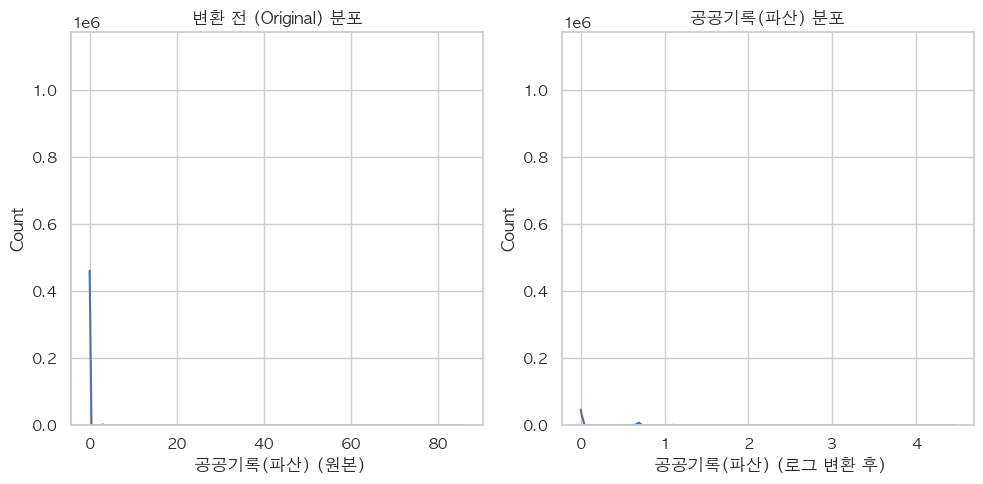

In [32]:
# 로그 변환 적용
acc_log['pub_rec'] = np.log1p(acc_log['pub_rec'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc['pub_rec'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 공공기록(파산) (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['pub_rec'], kde=True)
plt.title('공공기록(파산) 분포')
plt.xlabel(' 공공기록(파산) (로그 변환 후)')

plt.tight_layout()
plt.show()

### pub_rec_bankruptcies

In [33]:
# pub_rec  == 0 이고 pub_rec_bankruptcies == Null 인 항목 개수

aa = acc_log.loc[(acc_log.pub_rec == 0) & (acc_log.pub_rec_bankruptcies.isnull())]
aa.shape[0]

677

In [34]:
# pub_rec  == 0 이고 pub_rec_bankruptcies == Null 인 항목들 pub_rec_bankruptcies 칼럼에서 0으로 만들기

acc_log.loc[
    (acc_log['pub_rec'] == 0) & (acc_log['pub_rec_bankruptcies'].isnull()),
    'pub_rec_bankruptcies'
] = 0


In [35]:
# 파산 기록 개수를 파산 기록 존재 여부로 변환 -> 없음:0, 1번 이상 있음:1, 알 수 없음:None
acc_log['pub_rec_bankruptcies'] = acc_log['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else x)

In [36]:
# 조건 만족하는 Null 값들은 0으로 대체됨
# 나머지 null 값 20개
acc_log.pub_rec_bankruptcies.isnull().sum()

np.int64(20)

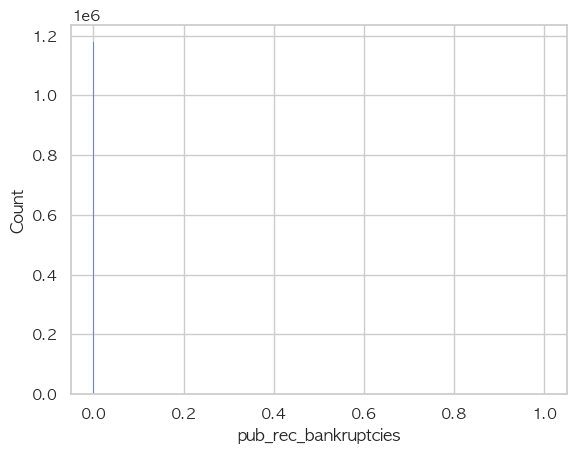

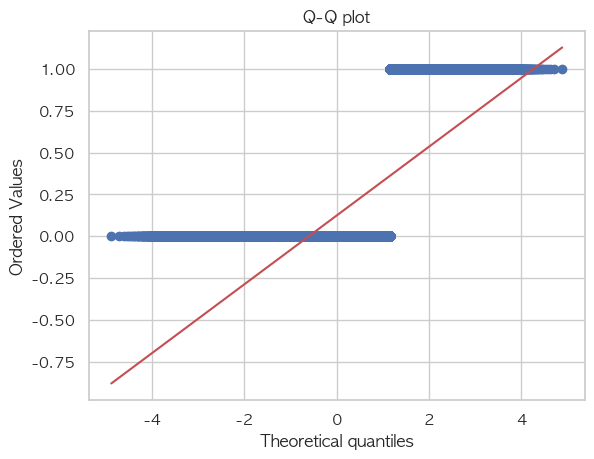

In [37]:
## pub_rec_bankruptcies
## 정규성 확인 & 로그 변환

# 히스토그램
sns.histplot(acc_log['pub_rec_bankruptcies'])
plt.show()

# Q-Q plot
stats.probplot(acc_log['pub_rec_bankruptcies'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.show()

# 로그 변환
# acc_log['pub_rec_bankruptcies'] = np.log1p(acc_log['pub_rec_bankruptcies'])  # 0 값도 처리되도록 log(1+x)

# plt.figure(figsize=(8, 4))
# sns.histplot(acc_log['pub_rec_bankruptcies'].dropna(), bins=50, kde=True)
# plt.title('pub_rec_bankruptcies 히스토그램 + KDE')
# plt.xlabel('log(pub_rec_bankruptcies + 1)')
# plt.ylabel('Count')
# plt.show()

In [38]:
# P-value 확인

stat, p = shapiro(acc_log['pub_rec_bankruptcies'].dropna())
print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

Shapiro-Wilk 검정 p-value: 0.0000


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345330.
  res = hypotest_fun_out(*samples, **kwds)


In [39]:
# 결측치 비율 확인

sss = acc_log.pub_rec_bankruptcies.isnull().sum()
s = acc_log.pub_rec_bankruptcies.shape[0]

round(sss / s * 100,2)


np.float64(0.0)

### mort_acc

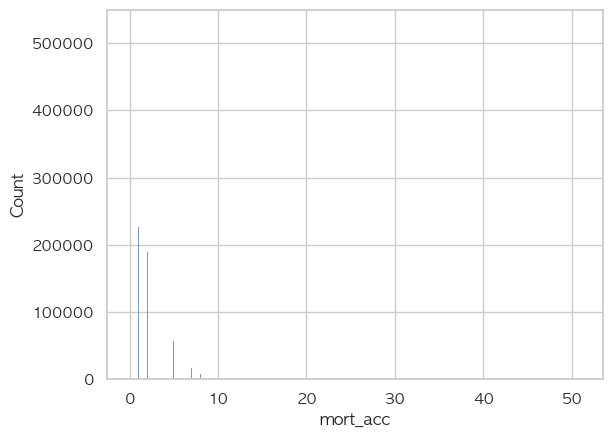

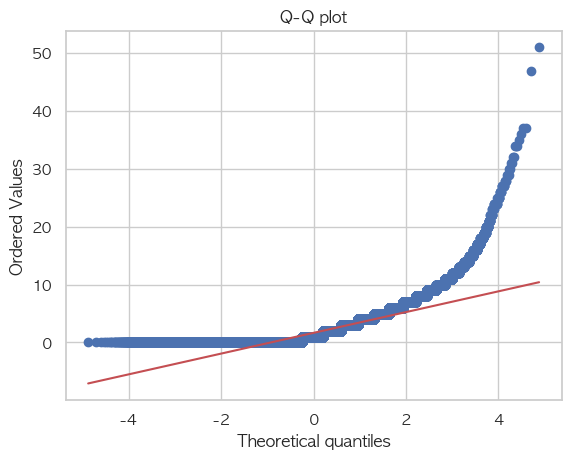

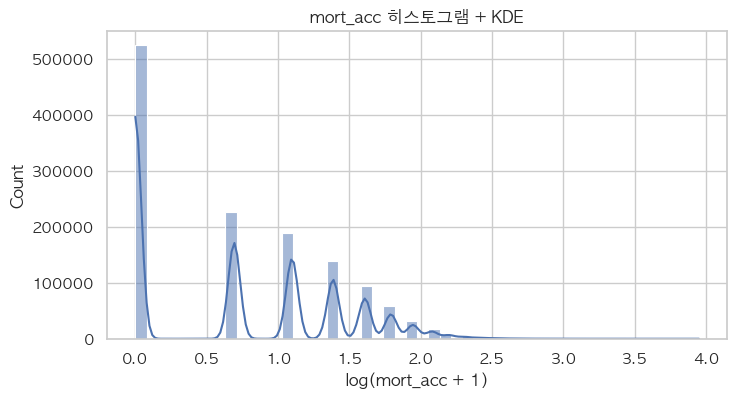

In [40]:
# 정규성확인

# 히스토그램
sns.histplot(acc['mort_acc'])
plt.show()

# Q-Q plot
stats.probplot(acc['mort_acc'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.show()

# 로그 변환
acc_log['mort_acc'] = np.log1p(acc_log['mort_acc'])  # 0 값도 처리되도록 log(1+x)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(acc_log['mort_acc'].dropna(), bins=50, kde=True)
plt.title('mort_acc 히스토그램 + KDE')
plt.xlabel('log(mort_acc + 1)')
plt.ylabel('Count')
plt.show()

In [41]:
# P-value 확인

stat, p = shapiro(acc['mort_acc'].dropna())
print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")


Shapiro-Wilk 검정 p-value: 0.0000


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1298069.
  res = hypotest_fun_out(*samples, **kwds)


In [42]:
# 결측치 비율 확인
sss = acc_log.mort_acc.isnull().sum()
s = acc_log.mort_acc.shape[0]

round(sss / s * 100,2)

np.float64(3.51)

### inq_last_6mths

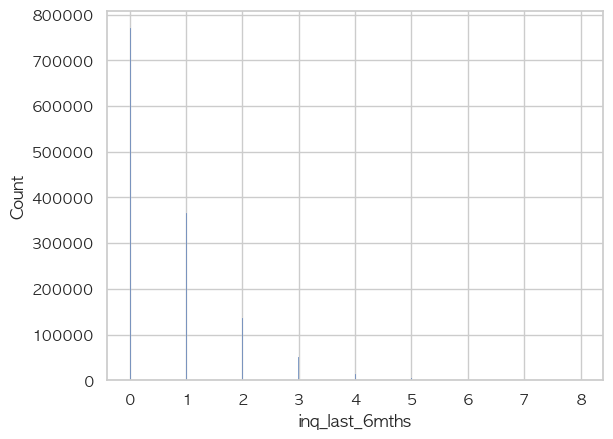

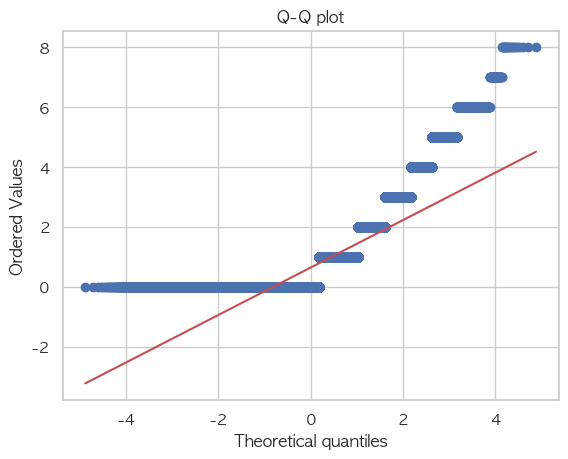

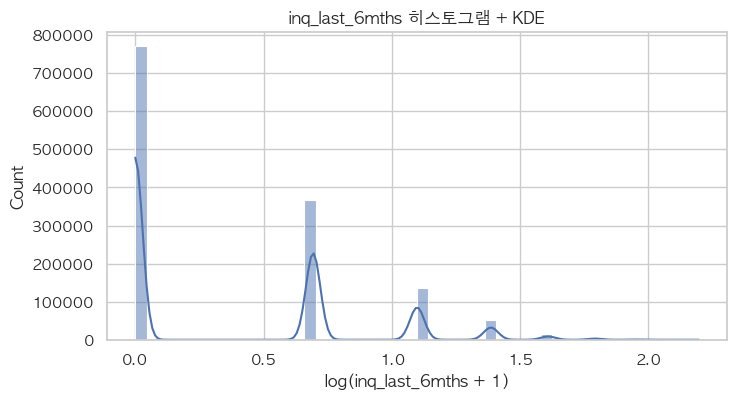

In [43]:
# 정규성 확인

# 히스토그램
sns.histplot(acc['inq_last_6mths'])
plt.show()

# Q-Q plot
stats.probplot(acc['inq_last_6mths'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.show()

# 로그 변환
acc_log['inq_last_6mths'] = np.log1p(acc_log['inq_last_6mths'])  # 0 값도 처리되도록 log(1+x)

plt.figure(figsize=(8, 4))
sns.histplot(acc_log['inq_last_6mths'].dropna(), bins=50, kde=True)
plt.title('inq_last_6mths 히스토그램 + KDE')
plt.xlabel('log(inq_last_6mths + 1)')
plt.ylabel('Count')
plt.show()

In [44]:
# P-value 확인

tat, p = shapiro(acc['inq_last_6mths'].dropna())
print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")


Shapiro-Wilk 검정 p-value: 0.0000


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1345349.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
# 결측치 비율

sss = acc_log.inq_last_6mths.isnull().sum()
s = acc_log.inq_last_6mths.shape[0]

round(sss / s * 100,2)

# 결측치 개수 1개

np.float64(0.0)

### num_bc_tl

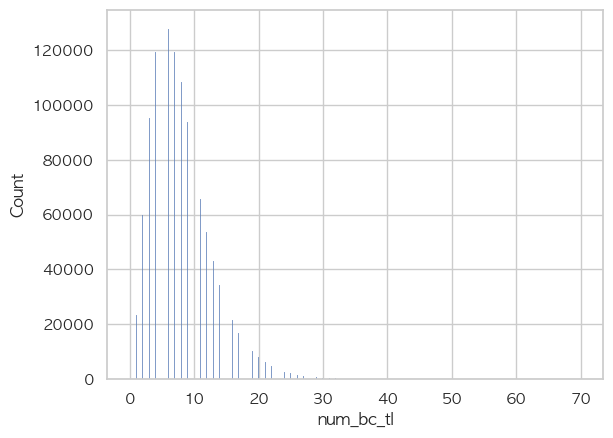

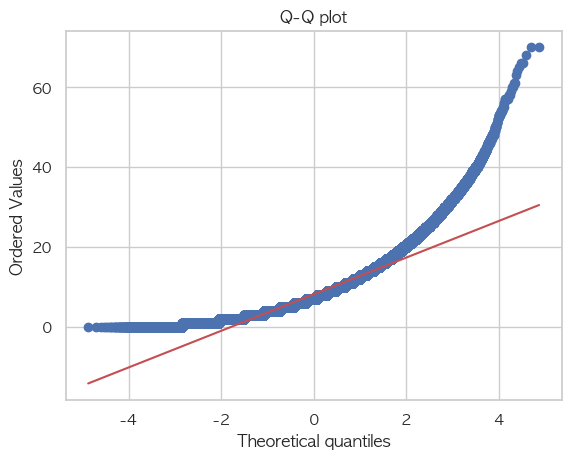

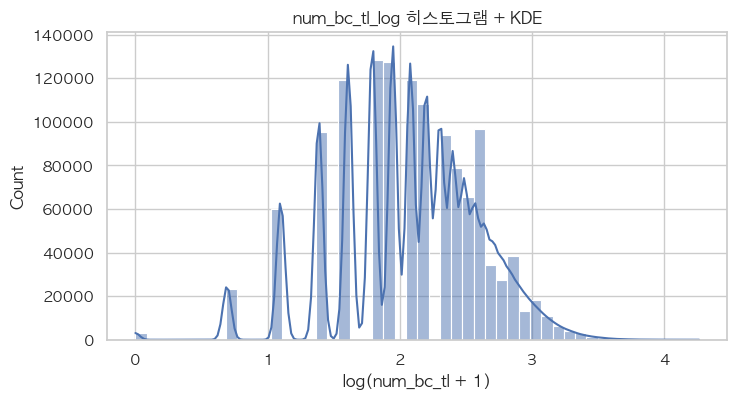

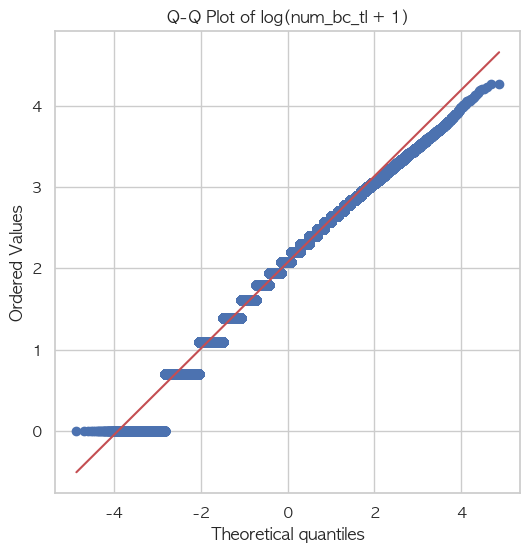

In [46]:
# 정규성 확인

# 히스토그램
sns.histplot(acc['num_bc_tl'])
plt.show()


# Q-Q plot
stats.probplot(acc['num_bc_tl'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.show()

# 로그변환
acc_log['num_bc_tl'] = np.log1p(acc_log['num_bc_tl'])  # 0 값도 처리되도록 log(1+x)

plt.figure(figsize=(8, 4))
sns.histplot(acc_log['num_bc_tl'].dropna(), bins=50, kde=True)
plt.title('num_bc_tl_log 히스토그램 + KDE')
plt.xlabel('log(num_bc_tl + 1)')
plt.ylabel('Count')
plt.show()

# 로그변환 후 QQplot 확인
plt.figure(figsize=(6, 6))
stats.probplot(acc_log['num_bc_tl'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q Plot of log(num_bc_tl + 1)')
plt.grid(True)
plt.show()


In [47]:
# P-value 확인

stat, p = shapiro(acc['num_bc_tl'].dropna())
print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

Shapiro-Wilk 검정 p-value: 0.0000


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1277823.
  res = hypotest_fun_out(*samples, **kwds)


In [48]:
# 결측치 확인

sss = acc_log.num_bc_tl.isnull().sum()
s = acc_log.num_bc_tl.shape[0]

round(sss / s * 100,2)

np.float64(5.02)

### num_actv_bc_tl

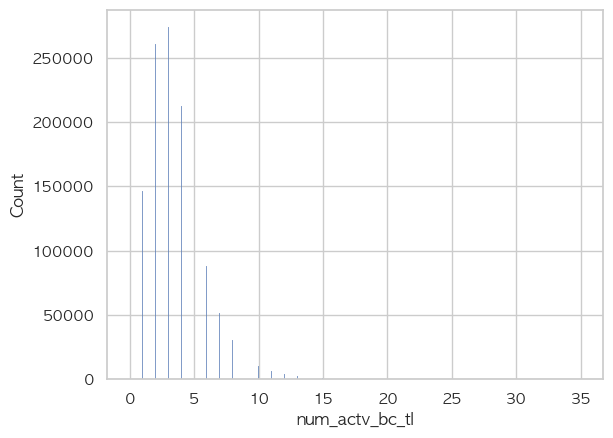

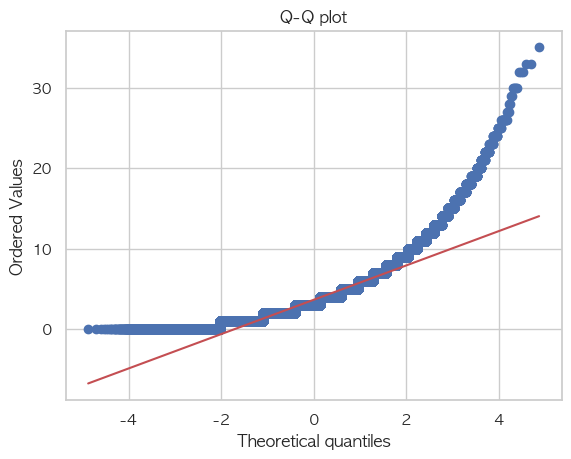

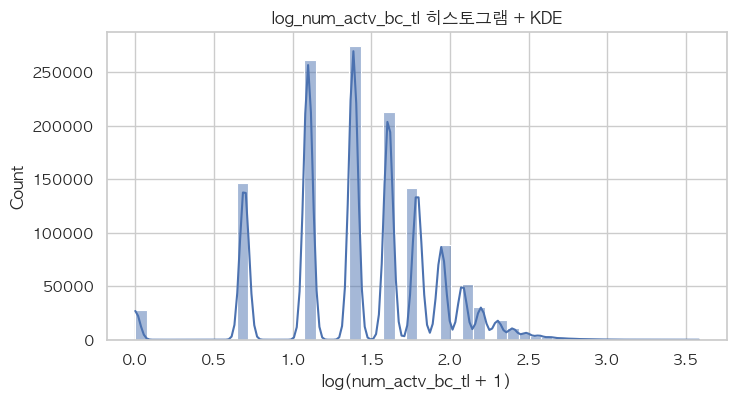

In [49]:
# 정규화 확인

# 히스토그램
sns.histplot(acc['num_actv_bc_tl'])
plt.show()

# Q-Q plot
stats.probplot(acc['num_actv_bc_tl'].dropna(), dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.show()

# 로그변환
acc_log['num_actv_bc_tl'] = np.log1p(acc_log['num_actv_bc_tl'])  # 0 값도 처리되도록 log(1+x)

plt.figure(figsize=(8, 4))
sns.histplot(acc_log['num_actv_bc_tl'].dropna(), bins=50, kde=True)
plt.title('log_num_actv_bc_tl 히스토그램 + KDE')
plt.xlabel('log(num_actv_bc_tl + 1)')
plt.ylabel('Count')
plt.show()

In [50]:
# P-value 확인

stat, p = shapiro(acc['num_actv_bc_tl'].dropna())
print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

Shapiro-Wilk 검정 p-value: 0.0000


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1277823.
  res = hypotest_fun_out(*samples, **kwds)


In [51]:
# 결측치 비율

sss = acc_log.num_actv_bc_tl.isnull().sum()
s = acc_log.num_actv_bc_tl.shape[0]

round(sss / s * 100,2)

np.float64(5.02)

In [52]:
acc_log.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.0    1177664
1.0     167666
Name: count, dtype: int64

## 상관관계 살펴보기

In [53]:
# 상관관계 살펴보기
corr = acc.corr(numeric_only=True)
corr_log = acc_log.corr(numeric_only=True)
corr.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,loan_status,pub_rec,pub_rec_bankruptcies,mort_acc,inq_last_6mths,num_bc_tl,num_actv_bc_tl
loan_amnt,1.000000,0.141676,0.953401,0.311803,0.032058,0.186193,0.318473,0.108486,0.208996,0.065598,-0.065905,-0.094479,0.224570,-0.015045,0.197737,0.195906
int_rate,0.141676,1.000000,0.153920,-0.072253,0.146890,-0.004387,-0.028137,0.243141,-0.042422,0.258806,0.053033,0.058909,-0.083278,0.215114,-0.083153,0.022619
installment,0.953401,0.153920,1.000000,0.302508,0.035798,0.176561,0.306762,0.126945,0.186021,0.051697,-0.054341,-0.086552,0.191562,0.007023,0.184847,0.198968
annual_inc,0.311803,-0.072253,0.302508,1.000000,-0.140488,0.134899,0.286459,0.035258,0.175861,-0.041758,-0.005446,-0.044551,0.214309,0.032833,0.126360,0.104247
dti,0.032058,0.146890,0.035798,-0.140488,1.000000,0.224897,0.109354,0.140805,0.173339,0.084499,-0.031251,-0.017547,-0.029557,-0.006469,0.051140,0.127996


<Axes: >

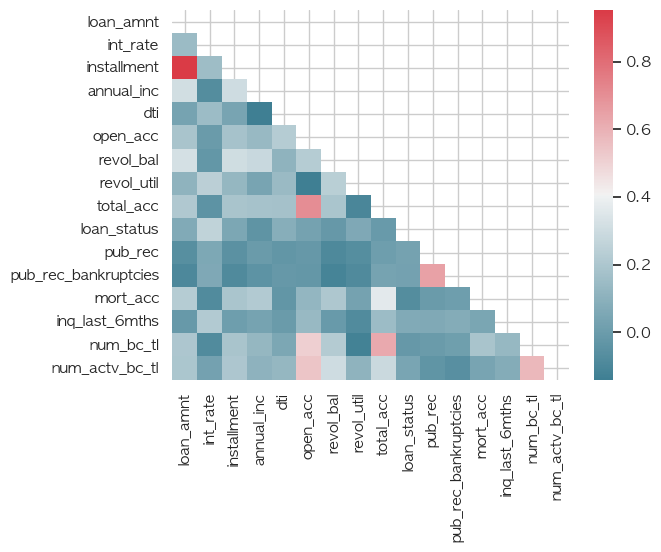

In [54]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = cmap)

<Axes: >

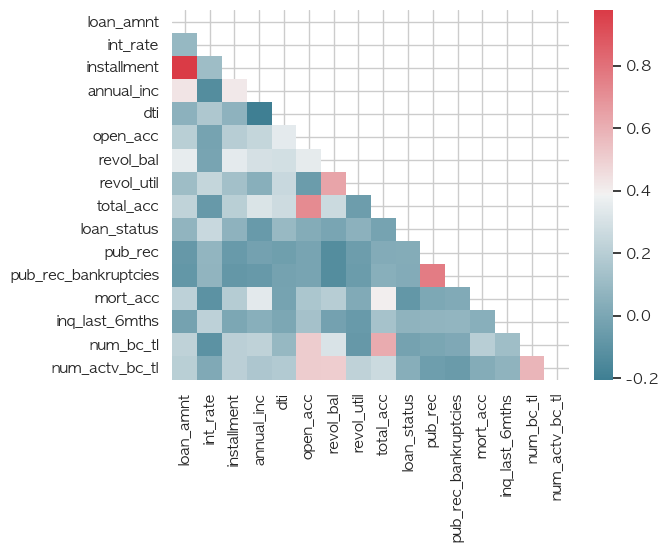

In [55]:
mask = np.zeros_like(corr_log, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_log, mask=mask, cmap = cmap)

# Null값 처리하기

## Null 값 하나씩 뜯어보기

In [56]:
acc_cleaned = acc_log.copy()

In [57]:
acc_cleaned.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
emp_title               85791
emp_length              78516
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                       374
open_acc                    0
revol_bal                   0
revol_util                857
total_acc                   0
loan_status                 0
pub_rec                     0
pub_rec_bankruptcies       20
mort_acc                47281
inq_last_6mths              1
num_bc_tl               67527
num_actv_bc_tl          67527
dtype: int64

In [58]:
# NULL 값 비율
dti_rate = round(acc_cleaned.dti.isnull().sum() / acc_cleaned.dti.shape[0] * 100 ,5)
print('dti null 값 비율: ' , dti_rate)
revol_util_rate = round(acc_cleaned.revol_util.isnull().sum() / acc_cleaned.revol_util.shape[0] * 100 ,5)
print('revol_util null 값 비율: ' , revol_util_rate)
pub_rec_bankruptcies_rate = round(acc_cleaned.pub_rec_bankruptcies.isnull().sum() / acc_cleaned.pub_rec_bankruptcies.shape[0] * 100 ,5)
print('pub_rec_bankruptcies null 값 비율: ' , pub_rec_bankruptcies_rate)
mort_acc_rate = round(acc_cleaned.mort_acc.isnull().sum() / acc_cleaned.mort_acc.shape[0] * 100 ,5)
print('mort_acc null 값 비율: ' , mort_acc_rate)
inq_last_6mths_rate = round(acc_cleaned.inq_last_6mths.isnull().sum() / acc_cleaned.inq_last_6mths.shape[0] * 100 ,5)
print('inq_last_6m null 값 비율: ' , inq_last_6mths_rate)
num_bc_tl_rate = round(acc_cleaned.num_bc_tl.isnull().sum() / acc_cleaned.num_bc_tl.shape[0] * 100 ,5)
print('num_bc_tl null 값 비율: ' , num_bc_tl_rate)
num_actv_bc_tl_rate = round(acc_cleaned.num_actv_bc_tl.isnull().sum() / acc_cleaned.num_actv_bc_tl.shape[0] * 100 ,5)
print('num_actv_bc_tl null 값 비율: ' , num_actv_bc_tl_rate)

dti null 값 비율:  0.0278
revol_util null 값 비율:  0.0637
pub_rec_bankruptcies null 값 비율:  0.00149
mort_acc null 값 비율:  3.5144
inq_last_6m null 값 비율:  7e-05
num_bc_tl null 값 비율:  5.01929
num_actv_bc_tl null 값 비율:  5.01929


In [59]:
# dti NA들이 연간 소득 0인 거랑 연관있는지 확인
print(acc_cleaned[acc_cleaned['annual_inc']==0].shape[0])
print(acc_cleaned.loc[acc_cleaned['annual_inc']==0, 'dti'].unique())
print(acc_cleaned[(acc_cleaned['annual_inc'] == 0) & (acc_cleaned['verification_status'] == 'Not Verified')].shape[0])
# 관련 존재! 연간 소득 0이면 dti NA임
acc_cleaned[(acc_cleaned['annual_inc']!=0) & (acc_cleaned['dti'].isnull())] # 연간 소득이 1 or 2
# 351

361
[nan]
336


,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,loan_status,pub_rec,pub_rec_bankruptcies,mort_acc,inq_last_6mths,num_bc_tl,num_actv_bc_tl
393517,8.699515,36 months,2.343727,5.271922,B,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,8.650149,3.063391,2.890372,0,0.000000,0.0,1.098612,0.000000,1.609438,1.386294
396850,10.596635,60 months,2.535283,6.805025,C,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,9.956744,4.300003,3.218876,0,0.000000,0.0,1.609438,0.000000,1.945910,1.609438
400351,9.305651,36 months,2.389680,5.885159,B,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,8.689633,3.563883,2.772589,0,0.000000,0.0,0.000000,0.000000,1.609438,1.386294
482204,7.783224,36 months,2.439735,4.370839,B,NaN,NaN,RENT,0.693147,Not Verified,...,9.323580,4.003690,3.091042,1,0.000000,0.0,0.000000,0.693147,2.079442,1.386294
580384,10.085809,36 months,2.127041,6.628570,B,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,9.388989,4.021774,2.484907,0,0.000000,0.0,0.693147,0.000000,2.079442,1.386294
613193,9.798127,60 months,2.790551,6.087933,D,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,8.377011,3.493473,3.178054,1,0.693147,1.0,0.693147,0.000000,2.197225,1.098612
904130,8.987197,36 months,3.250762,5.773060,E,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,9.580455,4.310799,3.367296,1,0.000000,0.0,0.693147,0.000000,2.197225,1.098612
969234,10.308953,36 months,2.771964,6.960888,C,NaN,NaN,MORTGAGE,0.693147,Not Verified,...,9.576649,4.596129,3.135494,0,0.693147,1.0,1.386294,0.000000,1.609438,1.386294
1267047,9.615805,36 months,2.389680,6.195323,B,rn,10+ years,RENT,1.098612,Not Verified,...,8.165364,4.228293,3.218876,0,0.000000,0.0,1.386294,0.693147,2.079442,0.693147
1283581,8.188689,36 months,2.644755,4.813647,C,NaN,NaN,RENT,0.693147,Verified,...,8.692994,3.005683,2.833213,0,0.000000,0.0,0.000000,0.693147,1.945910,1.386294


In [60]:
# # 리볼빙 신용 총 한도 - total_rev_hi_lim 칼럼 있어야 확인 가능
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0) | (acc_cleaned['total_rev_hi_lim'].isnull())].shape[0])
# print('리볼빙 신용 총 한도가 0인 데이터 수', acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0)].shape[0], '\n 총 한도가 na인 데이터 수' , acc_cleaned[acc_cleaned['total_rev_hi_lim'].isnull()].shape[0])
# # 리볼빙 신용 총 한도 == 0 이면서 revol_util NA
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0) & (acc_cleaned['revol_util'].isnull())].shape[0])
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'].isnull()) & (acc_cleaned['revol_util'].isnull())].shape[0])
# acc_cleaned.loc[((acc_cleaned['total_rev_hi_lim'] != 0 ) & (acc_cleaned['total_rev_hi_lim'].notna())) & (acc_cleaned['revol_util'].isnull()), 'revol_util':'total_rev_hi_lim']

In [61]:
# 파산 기록 NA 값 확인
print(acc_cleaned[acc_cleaned['pub_rec_bankruptcies'] >= 0].shape[0])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'].notnull()) & (acc_cleaned['pub_rec_bankruptcies'].isnull()), ['pub_rec', 'pub_rec_bankruptcies', 'verification_status']])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] == 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull())].shape[0])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] == 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull()), ['pub_rec', 'pub_rec_bankruptcies', 'verification_status']].value_counts('verification_status'))
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] != 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull())])

1345330
         pub_rec  pub_rec_bankruptcies verification_status
957280  0.693147                   NaN        Not Verified
957294  0.693147                   NaN        Not Verified
957319  0.693147                   NaN        Not Verified
957355  0.693147                   NaN        Not Verified
957373  0.693147                   NaN        Not Verified
957384  0.693147                   NaN        Not Verified
957479  0.693147                   NaN        Not Verified
957498  0.693147                   NaN        Not Verified
957543  0.693147                   NaN        Not Verified
957569  0.693147                   NaN        Not Verified
957600  0.693147                   NaN        Not Verified
957662  0.693147                   NaN        Not Verified
957673  0.693147                   NaN        Not Verified
957709  0.693147                   NaN        Not Verified
957710  0.693147                   NaN        Not Verified
957774  1.098612                   NaN        No

In [62]:
# mort_acc - 모기지 대출 계좌수
print(acc_cleaned[acc_cleaned['mort_acc'] >= 0].shape[0]) # 0 존재
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'NONE') & (acc_cleaned['mort_acc'].isnull())])
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'MORTGAGE') & (acc_cleaned['mort_acc'].isnull())].shape[0])
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'MORTGAGE') & (acc_cleaned['mort_acc'].isnull())].value_counts(['verification_status']))
print(acc_cleaned[(acc_cleaned['home_ownership'].isin(['RENT', 'OWN', 'ANY', 'OTHER'])) & (acc_cleaned['mort_acc'].isnull())].value_counts(['home_ownership', 'verification_status']))


1298069
        loan_amnt        term  int_rate  installment grade emp_title  \
957583   9.210340   36 months  2.047693     5.743708     A       ups   
957924   8.294050   36 months  2.265921     4.855228     B       NaN   
957925   7.937375   36 months  2.163323     4.484696     B       NaN   

       emp_length home_ownership  annual_inc verification_status  ...  \
957583    5 years           NONE   10.007893        Not Verified  ...   
957924   < 1 year           NONE   11.512935        Not Verified  ...   
957925   < 1 year           NONE   11.695255        Not Verified  ...   

       revol_bal  revol_util  total_acc  loan_status  pub_rec  \
957583  8.469682    2.272126   3.135494            0      0.0   
957924  9.006509    2.766319   2.197225            0      0.0   
957925  9.006509    2.766319   2.197225            0      0.0   

        pub_rec_bankruptcies  mort_acc  inq_last_6mths  num_bc_tl  \
957583                   0.0       NaN        0.000000        NaN   
957924     

In [63]:
acc_cleaned.groupby('home_ownership')['mort_acc'].agg(['mean', 'median'])

,mean,median
home_ownership,,
ANY,0.698235,0.693147
MORTGAGE,1.142048,1.098612
NONE,0.800118,0.693147
OTHER,0.665722,0.693147
OWN,0.603528,0.693147
RENT,0.256640,0.000000


In [64]:
# inq_last_6mths 지난 6개월간 신용조회 횟수
# na 값있는 행 확인
print(acc_cleaned[acc_cleaned['inq_last_6mths'].isna()])
print(acc_cleaned[acc_cleaned['inq_last_6mths'] == 0].shape[0])

        loan_amnt        term  int_rate  installment grade  \
656123  10.463103   60 months  2.282382     6.606934     B   

                   emp_title emp_length home_ownership  annual_inc  \
656123  subcontracts manager  10+ years       MORTGAGE   11.608245   

       verification_status  ... revol_bal  revol_util  total_acc  loan_status  \
656123     Source Verified  ...  7.319202    1.504077   3.610918            0   

        pub_rec  pub_rec_bankruptcies  mort_acc  inq_last_6mths  num_bc_tl  \
656123      0.0                   0.0  1.609438             NaN   2.397895   

        num_actv_bc_tl  
656123        0.693147  

[1 rows x 23 columns]
770442


In [65]:
acc_cleaned['inq_last_6mths'].agg(['mean', 'median'])

mean      0.378429
median    0.000000
Name: inq_last_6mths, dtype: float64

In [66]:
acc_cleaned.loc[acc_cleaned['grade'] == 'B'].groupby(['grade', 'home_ownership', 'verification_status'])['inq_last_6mths'].agg(['mean', 'median'])

mean    median
grade home_ownership verification_status                    
B     ANY            Not Verified         0.252752  0.000000
                     Source Verified      0.273011  0.000000
                     Verified             0.328593  0.000000
      MORTGAGE       Not Verified         0.329365  0.000000
                     Source Verified      0.330444  0.000000
                     Verified             0.369337  0.000000
      NONE           Not Verified         0.414151  0.346574
                     Verified             0.276101  0.000000
      OTHER          Not Verified         0.520168  0.693147
                     Source Verified      0.496981  0.693147
                     Verified             0.676157  0.693147
      OWN            Not Verified         0.314145  0.000000
                     Source Verified      0.316084  0.000000
                     Verified             0.327683  0.000000
      RENT           Not Verified         0.290246  0.000000
                     Source Verified      0.287215  0.000000
                     Verified             0.292471  0.000000

In [67]:
# num_bc_tl & num_actv_bc_tl
# 총 신용카드 계좌 수, 활성화 된 신용카드 계좌 수
print(acc_cleaned[acc_cleaned['num_bc_tl'].isnull() & acc_cleaned['num_actv_bc_tl'].isnull()].shape[0])
print(acc_cleaned[acc_cleaned['num_bc_tl'] == 0].shape[0])
print(acc_cleaned[acc_cleaned['num_bc_tl'].isnull() & acc_cleaned['num_actv_bc_tl'].isnull() & acc_cleaned['mort_acc'].isnull()].shape[0])

67527
2901
47281


In [68]:
print(acc_cleaned['num_actv_bc_tl'].agg(['mean', 'median']))
print(acc_cleaned['num_bc_tl'].agg(['mean', 'median']))

mean      1.423227
median    1.386294
Name: num_actv_bc_tl, dtype: float64
mean      2.073449
median    2.079442
Name: num_bc_tl, dtype: float64


## 찐찐 Null값 처리하기

* dti null 값 비율:  0.02893
* revol_util null 값 비율:  0.07387
* pub_rec_bankruptcies null 값 비율:  0.0638
* mort_acc null 값 비율:  4.15554
* inq_last_12m null 값 비율:  62.41306
* num_bc_tl null 값 비율:  5.92643
* num_actv_bc_tl null 값 비율:  5.92643

In [69]:
# 각 컬럼의 결측치 개수와 비율을 함께 보기
null_count = acc_cleaned.isnull().sum()
null_ratio = acc_cleaned.isnull().sum() / acc_cleaned.shape[0]

pd.DataFrame({
    'null_count': null_count,
    'null_ratio': null_ratio
})


,null_count,null_ratio
loan_amnt,0,0.000000e+00
term,0,0.000000e+00
int_rate,0,0.000000e+00
installment,0,0.000000e+00
grade,0,0.000000e+00
emp_title,85791,6.376854e-02
emp_length,78516,5.836102e-02
home_ownership,0,0.000000e+00
annual_inc,0,0.000000e+00
verification_status,0,0.000000e+00


### dti , revol_util , pub_rec_bankruptcies , inq_last_6mths

In [70]:
# 결측치 미미한 항목들 해당 칼럼에서 dropna 실행
acc_cleaned = acc_cleaned.dropna(subset = ['dti', 'revol_util', 'pub_rec_bankruptcies', 'inq_last_6mths'], axis=0)

In [71]:
# 위에서 확인해봤을 때, 주택 소유 상태에 따라 주택 계좌 수 평균, 중앙값이 달랐음
# mort_acc null 값 처리를 위해 log 씌운 값 평균으로 대체
home_mort_mean = acc_cleaned.groupby('home_ownership')['mort_acc'].mean().to_dict()
home_mort_mean

{'ANY': 0.7006846219703363,
 'MORTGAGE': 1.1420974138960198,
 'NONE': 0.800118155975811,
 'OTHER': 0.6657224603971139,
 'OWN': 0.6034302298579622,
 'RENT': 0.2565849605390124}

### mort_acc 

In [72]:
# mort_acc null 값 처리  - home_ownership에 따른 mort_acc 평균값으로 대체
acc_cleaned['mort_acc'] = acc_cleaned['mort_acc'].fillna(
    acc_cleaned['home_ownership'].map(home_mort_mean)
)

### inq_last_12m , num_bc_tl , num_actv_bc_tl

In [73]:
# 평균값으로 null 값들 대체 - num_bc_tl(총 신용카드 계좌 수), num_actv_bc_tl(활성화 된 신용카드 계좌 수)
# 로그씌운 값이라 평균값으로 통일!
acc_cleaned['num_bc_tl'] = acc_cleaned['num_bc_tl'].fillna(acc_cleaned['num_bc_tl'].mean())
acc_cleaned['num_actv_bc_tl'] = acc_cleaned['num_actv_bc_tl'].fillna(acc_cleaned['num_actv_bc_tl'].mean())
acc_cleaned.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
emp_title               85376
emp_length              78109
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                         0
open_acc                    0
revol_bal                   0
revol_util                  0
total_acc                   0
loan_status                 0
pub_rec                     0
pub_rec_bankruptcies        0
mort_acc                    0
inq_last_6mths              0
num_bc_tl                   0
num_actv_bc_tl              0
dtype: int64

In [74]:
# 좀 더 편하게 사용하려고 csv 파일로 저장
# acc_cleaned.to_csv('acc_cleaned.csv', index=False)

In [75]:
# csv file 이용 - 필요없으면 주석처리하기!
# acc_cleaned = pd.read_csv('acc_cleaned.csv')

# 이상치 처리

## 숫자형 변수들 이상치

## IQR

### dti

In [78]:
# dti 의 이상치 개수 41279 _ IQR 사용 

Q1 = acc_cleaned['dti'].quantile(0.25)
Q3 = acc_cleaned['dti'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_dti = acc_cleaned[(acc_cleaned['dti'] < lower_bound) | (acc_cleaned['dti'] > upper_bound)]

print('이상치 개수: ' , len(outliers_dti))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.dti))
print('이상치 비율: ', round(len(outliers_dti) / len(acc_cleaned.dti) * 100 , 2), '%' )


이상치 개수:  41279
해당 칼럼 전체 개수:  1344099
이상치 비율:  3.07 %


### revol_util

In [79]:
# revol_util 이상치

Q1 = acc_cleaned['revol_util'].quantile(0.25)
Q3 = acc_cleaned['revol_util'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_revol_util = acc_cleaned[(acc_cleaned['revol_util'] < lower_bound) | (acc_cleaned['revol_util'] > upper_bound)]

print('이상치 개수: ' , len(outliers_revol_util))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.revol_util))
print('이상치 비율: ', round(len(outliers_revol_util) / len(acc_cleaned.revol_util) * 100 , 2), '%' )


이상치 개수:  67650
해당 칼럼 전체 개수:  1344099
이상치 비율:  5.03 %


### pub_rec_bankruptcies

In [80]:
# pub_rec_bankruptcies(파산 기록수) 이상치

Q1 = acc_cleaned['pub_rec_bankruptcies'].quantile(0.25)
Q3 = acc_cleaned['pub_rec_bankruptcies'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_rec_bnkrcys = acc_cleaned[(acc_cleaned['pub_rec_bankruptcies'] < lower_bound) | (acc_cleaned['pub_rec_bankruptcies'] > upper_bound)]

print('이상치 개수: ' , len(outliers_rec_bnkrcys))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.pub_rec_bankruptcies))
print('이상치 비율: ', round(len(outliers_rec_bnkrcys) / len(acc_cleaned.pub_rec_bankruptcies) * 100 , 2), '%' )

이상치 개수:  167613
해당 칼럼 전체 개수:  1344099
이상치 비율:  12.47 %


### mort_acc

In [81]:
# mort_acc 이상치

Q1 = acc_cleaned['mort_acc'].quantile(0.25)
Q3 = acc_cleaned['mort_acc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_mort_acc = acc_cleaned[(acc_cleaned['mort_acc'] < lower_bound) | (acc_cleaned['mort_acc'] > upper_bound)]

print('이상치 개수: ' , len(outliers_mort_acc))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.mort_acc))
print('이상치 비율: ', round(len(outliers_mort_acc) / len(acc_cleaned.mort_acc) * 100 , 2), '%' )

이상치 개수:  13
해당 칼럼 전체 개수:  1344099
이상치 비율:  0.0 %


### num_bc_tl

In [82]:
# num_bc_tl 이상치

Q1 = acc_cleaned['num_bc_tl'].quantile(0.25)
Q3 = acc_cleaned['num_bc_tl'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_num_bc_tl = acc_cleaned[(acc_cleaned['num_bc_tl'] < lower_bound) | (acc_cleaned['num_bc_tl'] > upper_bound)]

print('이상치 개수: ' , len(outliers_num_bc_tl))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.num_bc_tl))
print('이상치 비율: ', round(len(outliers_num_bc_tl) / len(acc_cleaned.num_bc_tl) * 100 , 2), '%' )

이상치 개수:  32161
해당 칼럼 전체 개수:  1344099
이상치 비율:  2.39 %


### num_actv_bc_tl

In [83]:
# num_actv_bc_tl 이상치

Q1 = acc_cleaned['num_actv_bc_tl'].quantile(0.25)
Q3 = acc_cleaned['num_actv_bc_tl'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_num_actv_bc_tl = acc_cleaned[(acc_cleaned['num_actv_bc_tl'] < lower_bound) | (acc_cleaned['num_actv_bc_tl'] > upper_bound)]

print('이상치 개수: ' , len(outliers_num_actv_bc_tl))
print('해당 칼럼 전체 개수: ', len(acc_cleaned.num_actv_bc_tl))
print('이상치 비율: ', round(len(outliers_num_actv_bc_tl) / len(acc_cleaned.num_actv_bc_tl) * 100 , 2), '%' )

이상치 개수:  28143
해당 칼럼 전체 개수:  1344099
이상치 비율:  2.09 %


## Z-score

In [84]:
acc_cleaned.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
emp_title               85376
emp_length              78109
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                         0
open_acc                    0
revol_bal                   0
revol_util                  0
total_acc                   0
loan_status                 0
pub_rec                     0
pub_rec_bankruptcies        0
mort_acc                    0
inq_last_6mths              0
num_bc_tl                   0
num_actv_bc_tl              0
dtype: int64

In [85]:
acc_cleaned.select_dtypes(exclude='object').columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'loan_status', 'pub_rec',
       'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths', 'num_bc_tl',
       'num_actv_bc_tl'],
      dtype='object')

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 2. Z-스코어를 계산할 컬럼 목록 정의 (이미 로그 변환된 컬럼들)

columns_for_zscore = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec',
       'mort_acc', 'inq_last_6mths', 'num_bc_tl',
       'num_actv_bc_tl']

# 3. 해당 로그 변환된 컬럼들만 선택하고 결측치 처리
# StandardScaler는 NaN 값을 처리할 수 없으므로, 결측치 처리 필수
data_to_scale = acc_cleaned[columns_for_zscore].copy()

initial_rows = len(data_to_scale)
data_to_scale.dropna(inplace=True) # 결측치가 있는 행 제거 - 원래 결측치 없어서

print(f"로그 변환된 데이터의 Z-스코어 계산 전 행 수: {initial_rows}")
print("-" * 30)


# inf, -inf → NaN 으로 변환
data_to_scale.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 제거
data_to_scale.dropna(inplace=True)

# 4. StandardScaler를 사용하여 로그 변환된 데이터에 Z-스코어 계산
scaler = StandardScaler()
scaled_data_array = scaler.fit_transform(data_to_scale)

# 5. Z-스코어 결과를 새로운 DataFrame으로 변환
# 컬럼명에 '_log_zscore'를 붙여 로그 변환 후 Z-스코어임을 명시
zscore_column_names = [f'{col}_zscore' for col in columns_for_zscore] # 예: 'dti_log_zscore'
zscore_df = pd.DataFrame(scaled_data_array, columns=zscore_column_names, index=data_to_scale.index)

# 6. 원본 'acc_cleaned' 데이터프레임에 Z-스코어 컬럼들 추가
# 이전에 혹시 zscore 컬럼이 추가되어 있었다면 삭제하고 다시 join (이전 오류 방지 로직)
for col_name in zscore_column_names:
    if col_name in acc_cleaned.columns:
        print(f"'{col_name}' 컬럼이 이미 존재하여 삭제 후 다시 추가합니다.")
        acc_cleaned.drop(columns=[col_name], inplace=True)

acc_cleaned = acc_cleaned.join(zscore_df)


rows_after_dropna = len(data_to_scale)

# --- 로그 변환된 Z-스코어 기반 이상치 탐지 및 통계 출력 ---
print("\n--- 로그 변환된 Z-스코어 기반 이상치 탐지 통계 ---")

# 이상치 판단 기준 Z-스코어 임계값 설정
zscore_threshold = 3 # 절댓값이 3 이상인 경우 이상치로 간주

outlier_summary = {}

# 이제 실제 원본 컬럼 이름이 아닌, Z-스코어를 계산한 로그 변환 컬럼 이름을 사용합니다.
for col_log_name in columns_for_zscore:
    zscore_col_name = f'{col_log_name}_zscore' # 'dti_log_zscore'
    original_col_name = col_log_name.replace('_log', '') # 'dti_log' -> 'dti'

    # 해당 Z-스코어 컬럼이 acc_cleaned에 존재하는지 확인
    if zscore_col_name not in acc_cleaned.columns:
        print(f"경고: '{col_log_name}'에 대한 Z-스코어 컬럼 '{zscore_col_name}'이(가) 'acc_cleaned' 데이터프레임에 없습니다.")
        continue

    # 원본 컬럼의 전체 유효 값(NaN 제외) 개수 (참고용, 로그 변환 전 원본 컬럼 기준)
    # 만약 원본 컬럼이 NaN이었다면 로그 변환된 컬럼도 NaN이므로, 동일한 행 수가 될 것입니다.
    total_original_non_nan_count = acc_cleaned[col_log_name].dropna().count()

    # Z-스코어 임계값을 넘어서는 이상치 개수 (로그 변환된 값 기준)
    num_outliers = acc_cleaned[acc_cleaned[zscore_col_name].notna() &
                       ((acc_cleaned[zscore_col_name] > zscore_threshold) |
                        (acc_cleaned[zscore_col_name] < -zscore_threshold))].shape[0]

    # 이상치 비율 계산
    outlier_percentage = (num_outliers / total_original_non_nan_count * 100) if total_original_non_nan_count > 0 else 0

    outlier_summary[original_col_name] = { # 요약 테이블에는 원본 컬럼명으로 표시
        '원본 전체 유효 값 개수': total_original_non_nan_count,
        '로그 변환 Z-스코어 이상치 개수': num_outliers,
        '로그 변환 Z-스코어 이상치 비율 (%)': f"{outlier_percentage:.2f}%"
    }

    print(f"\n컬럼: '{original_col_name}' (로그 변환된 Z-스코어 기반)")
    print(f"  - 해당 로그 변환 컬럼의 전체 유효 값 개수: {total_original_non_nan_count}")
    print(f"  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > {zscore_threshold}): {num_outliers}개")
    print(f"  - 이상치 비율: {outlier_percentage:.2f}%")

print("\n--- 전체 이상치 요약 테이블 (로그 변환 Z-스코어 기준) ---")
print(pd.DataFrame.from_dict(outlier_summary, orient='index'))

# 옵션: 로그 변환된 Z-스코어 이상치 데이터의 원본 값 및 로그 변환 값 확인 (예: 'dti')
# print("\n--- 'dti' 컬럼의 실제 이상치 데이터 (로그 변환 Z-스코어 기준) ---")
# # 원본 'dti'와 로그 변환된 'dti_log', 그리고 Z-스코어 'dti_log_zscore'를 함께 출력
# dti_log_outliers = acc[acc['dti_log_zscore'].notna() &
#                    ((acc['dti_log_zscore'] > zscore_threshold) |
#                     (acc['dti_log_zscore'] < -zscore_threshold))]
# print(dti_log_outliers[['dti', 'dti_log', 'dti_log_zscore']])

로그 변환된 데이터의 Z-스코어 계산 전 행 수: 1344099
------------------------------

--- 로그 변환된 Z-스코어 기반 이상치 탐지 통계 ---

컬럼: 'loan_amnt' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 9621개
  - 이상치 비율: 0.72%

컬럼: 'int_rate' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 0개
  - 이상치 비율: 0.00%

컬럼: 'installment' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 11538개
  - 이상치 비율: 0.86%

컬럼: 'annual_inc' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 10266개
  - 이상치 비율: 0.76%

컬럼: 'dti' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 18909개
  - 이상치 비율: 1.41%

컬럼: 'open_acc' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 6387개
  - 이상치 비율: 0.48%

컬럼: 'revol_bal' (로그 변환된 Z-스코어 기반)
  - 해당 로그 변환 컬럼의 전체 유효 값 개수: 1344099
  - 이상치 개수 (로그 변환 Z-스코어 절댓값 > 3): 16143개
  - 이상치 비율

### Z-score 이후 null 값 제거 & 이상치 제거

In [87]:
# z-score 이후 null 개수 확인

acc_cleaned.select_dtypes(include='number').isnull().sum()

loan_amnt                0
int_rate                 0
installment              0
annual_inc               0
dti                      0
open_acc                 0
revol_bal                0
revol_util               0
total_acc                0
loan_status              0
pub_rec                  0
pub_rec_bankruptcies     0
mort_acc                 0
inq_last_6mths           0
num_bc_tl                0
num_actv_bc_tl           0
loan_amnt_zscore         2
int_rate_zscore          2
installment_zscore       2
annual_inc_zscore        2
dti_zscore               2
open_acc_zscore          2
revol_bal_zscore         2
revol_util_zscore        2
total_acc_zscore         2
pub_rec_zscore           2
mort_acc_zscore          2
inq_last_6mths_zscore    2
num_bc_tl_zscore         2
num_actv_bc_tl_zscore    2
dtype: int64

In [88]:
# null 값있는 행 제거

acc_cleaned = acc_cleaned.dropna(subset=acc_cleaned.select_dtypes(include='number').columns)


In [89]:
# 제거 확인

acc_cleaned.select_dtypes(include='number').isnull().sum()

loan_amnt                0
int_rate                 0
installment              0
annual_inc               0
dti                      0
open_acc                 0
revol_bal                0
revol_util               0
total_acc                0
loan_status              0
pub_rec                  0
pub_rec_bankruptcies     0
mort_acc                 0
inq_last_6mths           0
num_bc_tl                0
num_actv_bc_tl           0
loan_amnt_zscore         0
int_rate_zscore          0
installment_zscore       0
annual_inc_zscore        0
dti_zscore               0
open_acc_zscore          0
revol_bal_zscore         0
revol_util_zscore        0
total_acc_zscore         0
pub_rec_zscore           0
mort_acc_zscore          0
inq_last_6mths_zscore    0
num_bc_tl_zscore         0
num_actv_bc_tl_zscore    0
dtype: int64

In [90]:
# 

zscore_threshold = 3

# Z-스코어 컬럼들
columns_for_zscore = [
    'dti', 'revol_util', 'pub_rec_bankruptcies', 
    'mort_acc', 'num_bc_tl', 'num_actv_bc_tl'
]

zscore_columns = [f"{col}_zscore" for col in columns_for_zscore]

# 이상치가 하나라도 포함된 행 인덱스 수집
outlier_indices = set()

for original_col, zscore_col in zip(columns_for_zscore, zscore_columns):
    if zscore_col in acc_cleaned.columns:
        outlier_rows = acc_cleaned[acc_cleaned[zscore_col].abs() > zscore_threshold].index
        outlier_indices.update(outlier_rows)

print(f"총 삭제 대상 행 수: {len(outlier_indices):,}개")

# 해당 행 삭제
acc_cleaned = acc_cleaned.drop(index=outlier_indices).copy()

print(f"이상치 제거 후 남은 행 수: {len(acc_cleaned):,}")
print(f"z-score 로 제거한 이상치 비율 : { round((len(outlier_indices))/ (acc_cleaned.shape[0]),3) }")


총 삭제 대상 행 수: 63,760개
이상치 제거 후 남은 행 수: 1,280,337
z-score 로 제거한 이상치 비율 : 0.05


## 범주형 칼럼 인코딩하기

In [91]:
# 범주형 칼럼 확인
## 확인
acc_cleaned.select_dtypes(include='object').columns

Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'purpose'],
      dtype='object')

In [92]:
# term 칼럼 인코딩 ( 0,1 로 인코딩함)
# 새로운 칼럼 만들지 않고 기존 칼럼에 인코딩 된 내용 덮어씀

acc_cleaned.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [93]:
term_map = {' 36 months': 0, ' 60 months': 1}
acc_cleaned['term'] = acc_cleaned['term'].map(term_map)


In [94]:
acc_cleaned.term.value_counts()

term
0    969508
1    310829
Name: count, dtype: int64

In [95]:
# grade 인코딩 (1~7 등급으로 인코딩)

acc_cleaned.grade.value_counts()

grade
B    375746
C    366088
A    218222
D    191987
E     89270
F     30466
G      8558
Name: count, dtype: int64

In [96]:
grade_map = {'A': 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7}
acc_cleaned.grade = acc_cleaned.grade.map(grade_map)

acc_cleaned.grade.value_counts().sort_index()

grade
1    218222
2    375746
3    366088
4    191987
5     89270
6     30466
7      8558
Name: count, dtype: int64

In [97]:
# home_ownership 인코딩
# 원핫인코딩 사용

acc_cleaned.home_ownership.value_counts()

home_ownership
MORTGAGE    634446
RENT        509329
OWN         136120
ANY            268
OTHER          128
NONE            46
Name: count, dtype: int64

In [98]:
home_dummies = pd.get_dummies(acc_cleaned['home_ownership'], prefix='home', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, home_dummies], axis=1)


In [99]:
# home_ownership 원핫 인코딩 확인

acc_cleaned.filter(like='home_').head()


,home_ownership,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT
0,MORTGAGE,0,1,0,0,0,0
1,MORTGAGE,0,1,0,0,0,0
2,MORTGAGE,0,1,0,0,0,0
3,MORTGAGE,0,1,0,0,0,0
4,RENT,0,0,0,0,0,1


In [100]:
# verification_status 인코딩

acc_cleaned.verification_status.value_counts()

verification_status
Source Verified    496479
Verified           398091
Not Verified       385767
Name: count, dtype: int64

In [101]:
ver_dummies = pd.get_dummies(acc_cleaned['verification_status'], prefix='vrfc', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, ver_dummies], axis=1)

In [102]:
# verification_status 원핫인코딩 확인

acc_cleaned.filter(like='vrfc_').head()


,vrfc_Not Verified,vrfc_Source Verified,vrfc_Verified
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [103]:
# purpose 인코딩
# 1. 그룹화 시키기
# 2. 원핫인코딩

acc_cleaned.purpose.value_counts()



purpose
debt_consolidation    752866
credit_card           289265
home_improvement       77703
other                  69557
major_purchase         24893
medical                13960
small_business         13520
car                    12740
moving                  8464
vacation                8080
house                   6151
wedding                 2025
renewable_energy         842
educational              271
Name: count, dtype: int64

In [104]:
# purpose 그룹화 시키기
# 항목 14개-> 7개

def group_purpose(x):
    if x in ['debt_consolidation', 'credit_card']:
        return 'debt_related'
    elif x in ['home_improvement', 'house']:
        return 'housing'
    elif x in ['major_purchase', 'car', 'moving', 'vacation', 'wedding']:
        return 'consumption'
    elif x == 'small_business':
        return 'business'
    elif x in ['educational', 'medical']:
        return 'edu_medical'
    elif x == 'renewable_energy':
        return 'energy'
    else:
        return 'other'

acc_cleaned['purpose'] = acc_cleaned['purpose'].apply(group_purpose)

acc_cleaned['purpose'].value_counts()


purpose
debt_related    1042131
housing           83854
other             69557
consumption       56202
edu_medical       14231
business          13520
energy              842
Name: count, dtype: int64

In [105]:
purpose_dummies = pd.get_dummies((acc_cleaned.purpose), prefix='purp', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, purpose_dummies] , axis = 1)

In [106]:
# 인코딩 확인
acc_cleaned.filter(like='purp').head()

,purpose,purp_business,purp_consumption,purp_debt_related,purp_edu_medical,purp_energy,purp_housing,purp_other
0,debt_related,0,0,1,0,0,0,0
1,business,1,0,0,0,0,0,0
2,housing,0,0,0,0,0,1,0
3,consumption,0,1,0,0,0,0,0
4,debt_related,0,0,1,0,0,0,0


In [107]:
# 인코딩 되지 않은 원래 열 삭제
acc_cleaned = acc_cleaned.drop(['home_ownership', 'verification_status', 'purpose'], axis = 1)

#### 근속년수 처리

In [ ]:
# # 근속년수 처리
# acc_cleaned['emp_length'] = acc_cleaned['emp_length'].fillna('None')

# emp_length_ordered = {
#     'None': 0,         # 결측값 대체
#     '< 1 year': 1,
#     '1 year': 2,
#     '2 years': 3,
#     '3 years': 4,
#     '4 years': 5,
#     '5 years': 6,
#     '6 years': 7,
#     '7 years': 8,
#     '8 years': 9,
#     '9 years': 10,
#     '10+ years': 11
# }

# acc_cleaned['emp_length'] = acc_cleaned['emp_length'].map(emp_length_ordered)

## 직업 안정성 열 합치기

In [108]:
# 직업 bert 모델 돌린 것과 같이 합치기
emp_title_csv = pd.read_csv('acc_cleaned_with_job_score.csv')
emp_title_csv = emp_title_csv[['emp_title', 'SOC_major_group', 'Job Stability', 'Job Stability Score']]
emp_title_csv = emp_title_csv.drop_duplicates(subset='emp_title')
# 문자열 소문자 변환 + 앞뒤 공백제거
emp_title_csv['emp_title'] = emp_title_csv['emp_title'].apply(
    lambda x: x.lower().strip() if pd.notnull(x) else x
)
emp_title_csv = emp_title_csv.drop_duplicates(subset='emp_title')
# 직업 unique값과 전체 행 맞는지 확인
print(emp_title_csv.shape[0] == len(emp_title_csv.emp_title.unique()))
emp_title_csv.head()


True


,emp_title,SOC_major_group,Job Stability,Job Stability Score
0,leadman,99-0000 Unclassified Occupations,Low Stability,1
1,engineer,17-0000 Architecture and Engineering Occupations,Relatively Stable,3
2,truck driver,53-0000 Transportation and Material Moving Occ...,Variable Stability,2
3,contract specialist,13-0000 Business and Financial Operations Occu...,Relatively Stable,3
4,veterinary tecnician,99-0000 Unclassified Occupations,Low Stability,1


In [109]:
acc_cleaned = pd.merge(acc_cleaned, emp_title_csv, on = 'emp_title', how = 'left')
acc_cleaned.isnull().sum()/acc_cleaned.shape[0]

loan_amnt                0.000000
term                     0.000000
int_rate                 0.000000
installment              0.000000
grade                    0.000000
emp_title                0.062278
emp_length               0.057070
annual_inc               0.000000
dti                      0.000000
open_acc                 0.000000
revol_bal                0.000000
revol_util               0.000000
total_acc                0.000000
loan_status              0.000000
pub_rec                  0.000000
pub_rec_bankruptcies     0.000000
mort_acc                 0.000000
inq_last_6mths           0.000000
num_bc_tl                0.000000
num_actv_bc_tl           0.000000
loan_amnt_zscore         0.000000
int_rate_zscore          0.000000
installment_zscore       0.000000
annual_inc_zscore        0.000000
dti_zscore               0.000000
open_acc_zscore          0.000000
revol_bal_zscore         0.000000
revol_util_zscore        0.000000
total_acc_zscore         0.000000
pub_rec_zscore

In [110]:
# 직업 안정성이 null인데 직업은 null이 아닌 행들
acc_cleaned[acc_cleaned['Job Stability'].isnull() & acc_cleaned['emp_title'].notnull()].shape[0]/acc_cleaned.shape[0]

0.30677782490078787

In [111]:
acc_cleaned.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'annual_inc', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'loan_status', 'pub_rec',
       'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths', 'num_bc_tl',
       'num_actv_bc_tl', 'loan_amnt_zscore', 'int_rate_zscore',
       'installment_zscore', 'annual_inc_zscore', 'dti_zscore',
       'open_acc_zscore', 'revol_bal_zscore', 'revol_util_zscore',
       'total_acc_zscore', 'pub_rec_zscore', 'mort_acc_zscore',
       'inq_last_6mths_zscore', 'num_bc_tl_zscore', 'num_actv_bc_tl_zscore',
       'home_ANY', 'home_MORTGAGE', 'home_NONE', 'home_OTHER', 'home_OWN',
       'home_RENT', 'vrfc_Not Verified', 'vrfc_Source Verified',
       'vrfc_Verified', 'purp_business', 'purp_consumption',
       'purp_debt_related', 'purp_edu_medical', 'purp_energy', 'purp_housing',
       'purp_other', 'SOC_major_group', 'Job Stability',
       'Job Stability Score'],
      dtype='objec

# 모델

## 불균형 데이터 처리

#### z_score 사용 X

In [ ]:
# # z_score열 삭제
# acc_cleaned = acc_cleaned.drop(['loan_amnt_zscore', 'int_rate_zscore',
#        'installment_zscore', 'annual_inc_zscore', 'dti_zscore',
#        'open_acc_zscore', 'revol_bal_zscore', 'revol_util_zscore',
#        'total_acc_zscore', 'pub_rec_zscore', 'mort_acc_zscore',
#        'inq_last_6mths_zscore', 'num_bc_tl_zscore', 'num_actv_bc_tl_zscore'], axis = 1)

In [ ]:
# 1. 사용할 피처 선택

selected_features = ['loan_amnt', # 수치형 피처 예시
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'mort_acc',
 'inq_last_6mths',
#  'inq_last_12m',
 'num_bc_tl',
 'num_actv_bc_tl']

selected_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', # 'emp_title', 'emp_length',
        'annual_inc', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths', 'num_bc_tl',
       'num_actv_bc_tl', 'home_ANY', 'home_MORTGAGE', 'home_NONE',
       'home_OTHER', 'home_OWN', 'home_RENT', 'vrfc_Not Verified',
       'vrfc_Source Verified', 'vrfc_Verified', 'purp_business',
       'purp_consumption', 'purp_debt_related', 'purp_edu_medical',
       'purp_energy', 'purp_housing', 'purp_other']

logistic_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', # 'emp_title', 'emp_length', 
       'annual_inc',  'dti_zscore', 'open_acc', 'revol_bal',
       'revol_util_zscore', 'total_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'mort_acc_zscore', 'inq_last_6mths', 'num_bc_tl_zscore',
       'num_actv_bc_tl_zscore', 
       'home_ANY', 'home_MORTGAGE', 'home_NONE',
       'home_OTHER', 'home_OWN', 'home_RENT', 'vrfc_Not Verified',
       'vrfc_Source Verified', 'vrfc_Verified', 'purp_business',
       'purp_consumption', 'purp_debt_related', 'purp_edu_medical',
       'purp_energy', 'purp_housing', 'purp_other']

X = acc_cleaned[selected_features]
y = acc_cleaned['loan_status']  # 반드시 이 컬럼이 0(Good), 1(Default) 형태여야 함

# 2. train_test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )

In [ ]:
# # 2-1. train_val 데이터 나누기
# X_train, X_val, y_train, y_val = train_test_split(
#         X_train, y_train, test_size = 0.2, random_state = 42, stratify = y
#     )

# 3. SMOTE 오버샘플링 적용
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("\n▶ SMOTE 적용 후 클래스 분포:")
print(y_smote.value_counts())

# 3. RandomUnderSampler 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print("\n▶ RandomUnderSampler 적용 후 클래스 분포:")
print(y_rus.value_counts())

# 4. 모델 학습 및 평가 + 중요도 시각화 포함 함수 -> 아래 랜덤 포레스트에서 제대로!
# def train_and_evaluate(X_train, y_train, X_test, y_test, method):
#     rf_model = RandomForestClassifier(random_state=42)
#     rf_model.fit(X_train, y_train)
#     y_pred = rf_model.predict(X_test)

#     print(f"\n[{method}] 성능 평가 결과:")
#     print(classification_report(y_test, y_pred))

#     # 가장 중요한 변수 출력
#     most_important_idx = importances.argmax()
#     most_important_feature = feature_names[most_important_idx]
#     print("가장 중요한 변수:", most_important_feature)

#     # Feature Importance 시각화
#     importances = rf_model.feature_importances_
#     feature_names = X_train.columns

#     plt.figure(figsize=(10, 5))
#     plt.bar(range(len(importances)), importances, color='skyblue')
#     plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
#     plt.xlabel("Feature")
#     plt.ylabel("Importance")
#     plt.title(f"[{method}] Feature Importances (RandomForest)")
#     plt.tight_layout()
#     plt.show()




▶ SMOTE 적용 후 클래스 분포:
loan_status
0    818483
1    818483
Name: count, dtype: int64

▶ RandomUnderSampler 적용 후 클래스 분포:
loan_status
0    205786
1    205786
Name: count, dtype: int64


## Linear Regression

In [ ]:
# 4. Linear Regression statics 모델 학습 및 평가
def lr_stats(X, y, method, hyper = None):
    # 절편항 추가
    X_train = sm.add_constant(X)

    # 로지스틱 회귀 적합 (logit 모델)
    model = sm.Logit(y, X)
    result = model.fit()
    
    print(result.summary())
    print("p-value:")
    print(result.pvalues)
    print("Pseudo R-squared:")
    print(result.prsquared)
    

In [ ]:
# 4. Linear Regression sklearn 모델 학습 및 평가 + 시각화 포함 함수
def lr_sklearn(X_train, y_train, X_test, y_test, method, hyper = None):
    
    if hyper == None:
        hyper = {}  # 기본값: 빈 딕셔너리
    
    # 기본값 설정: random_state는 항상 고정
    hyper.setdefault('random_state', 42)
    
    # 4-1. 모델 학습 및 예측
    lr_model = LogisticRegression(**hyper)  # **kwargs → 키워드 기반 인자 여러 개를 받을 때
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    # 모델의 예측 확률
    y_proba = lr_model.predict_proba(X_test)[:, 1] 
    # ✅ 여기서는 대출을 다 갚지 봇하는 클래스(1)에 대한 확률만 사용

    # 4-2. 회귀 계수
    # coef_ + feature name 묶기
    coef_df = pd.DataFrame({
        'feature': X_train.columns.to_list(),
        'coefficient': lr_model.coef_[0]  # 이진 분류라 [0]으로 접근
    })

    print(coef_df)

    # 4-2. 성능 평가
    print(f"\n[{method}] 성능 평가 결과:")
    print(f'정확도 : {accuracy_score(y_test, y_pred)}')
    print(f"f1 score : {f1_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


    # 4-3. ROC 곡선 계산
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # fpr: False Positive Rate
    # tpr: True Positive Rate (재현율과 동일)
    # thresholds: 임계값(이 값을 기준으로 양성/음성 분류가 달라짐)

    # 4-4. AUC 계산
    auc_score = roc_auc_score(y_test, y_proba)
    # 4-5. ROC 곡선 시각화
    plt.figure()
    plt.plot(fpr, tpr, label=f'Logistic (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--') # 랜덤 분류선
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    print("ROC-AUC Score:", auc_score)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 10 μs


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 feature  coefficient
0              loan_amnt     1.741278
1                   term    -0.106146
2               int_rate     1.750760
3            installment    -1.469049
4             annual_inc    -0.287242
5                    dti     0.335580
6               open_acc     0.366789
7              revol_bal    -0.215750
8             revol_util     0.240844
9              total_acc    -0.209558
10               pub_rec    -0.059954
11  pub_rec_bankruptcies     0.159744
12              mort_acc    -0.102440
13        inq_last_6mths     0.118544
14             num_bc_tl    -0.045867
15        num_actv_bc_tl     0.306145
16              home_ANY    -0.543121
17         home_MORTGAGE    -2.394372
18             home_NONE    -0.141620
19            home_OTHER    -0.225466
20              home_OWN    -2.273431
21             home_RENT    -2.198611
22     vrfc_Not Verified    -1.853626
23  vrfc_Source Verified    -1.686221
24         vrfc_Verified    -1.744774
25         p

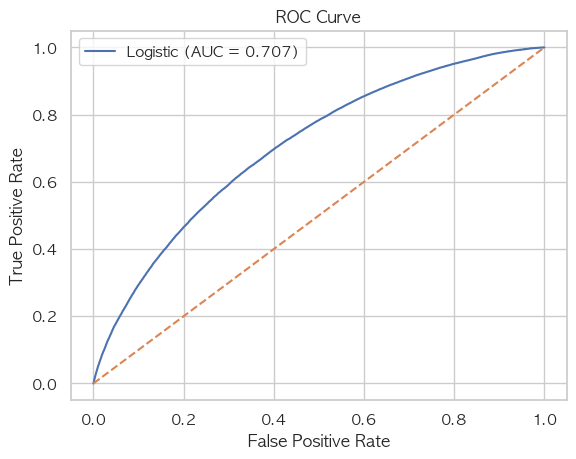

ROC-AUC Score: 0.7068151727211934


In [ ]:
%time # smote & Logistic Regression
lr_sklearn(X_smote, y_smote, X_test, y_test, "SMOTE")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 11 μs


/Users/t2023-m0052/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 feature  coefficient
0              loan_amnt     0.123900
1                   term     0.532846
2               int_rate     1.342956
3            installment     0.103893
4             annual_inc    -0.275555
5                    dti     0.274709
6               open_acc     0.224952
7              revol_bal    -0.164391
8             revol_util     0.160352
9              total_acc    -0.064339
10               pub_rec     0.246887
11  pub_rec_bankruptcies    -0.070772
12              mort_acc    -0.123343
13        inq_last_6mths     0.161715
14             num_bc_tl    -0.101551
15        num_actv_bc_tl     0.295068
16              home_ANY     0.004130
17         home_MORTGAGE    -0.639229
18             home_NONE     0.011286
19            home_OTHER     0.057512
20              home_OWN    -0.494137
21             home_RENT    -0.424034
22     vrfc_Not Verified    -0.600013
23  vrfc_Source Verified    -0.427581
24         vrfc_Verified    -0.456877
25         p

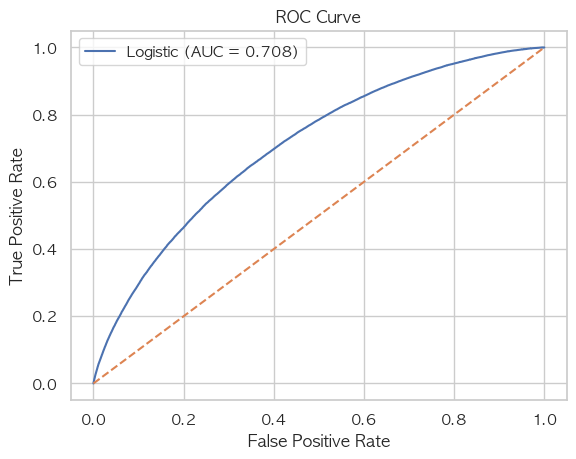

ROC-AUC Score: 0.708013653703722


In [ ]:
%time # smote & Logistic Regression
lr_sklearn(X_rus, y_rus, X_test, y_test, "RandomUnderSampler")

#### Grid Search

In [ ]:
## Grid Search
# # 샘플러 선택을 위한 dict
# samplers = {
#     'smote': SMOTE(random_state=42),
#     'under': RandomUnderSampler(random_state=42)
# }

# # 파이프라인 정의
# pipe = Pipeline([
#     ('sampler', SMOTE()),  # 임의의 초기값 (GridSearch에서 바뀔 예정)
#     ('clf', LogisticRegression(max_iter=1000, random_state=42))
# ])

# # 하이퍼 파라미터 그리드
# param_grid = [
#     {
#         'sampler': [SMOTE(random_state=42), RandomUnderSampler(random_state=42)],
#         'clf__solver': ['liblinear'],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__C': [0.01, 0.1, 1, 10]
#     },
#     {
#         'sampler': [SMOTE(random_state=42), RandomUnderSampler(random_state=42)],
#         'clf__solver': ['lbfgs', 'newton-cg', 'sag'],
#         'clf__penalty': ['l2'],
#         'clf__C': [0.01, 0.1, 1, 10]
#     },
#     {
#         'sampler': [SMOTE(random_state=42), RandomUnderSampler(random_state=42)],
#         'clf__solver': ['saga'],
#         'clf__penalty': ['l1', 'l2', 'elasticnet'],
#         'clf__C': [0.01, 0.1, 1, 10],
#         'clf__l1_ratio': [0.5]
#     }
# ]


# # GridSearchCV 실행
# grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
# grid.fit(X_train, y_train)

## Random Forest

In [ ]:
%time
# 모델 정의 및 학습
rf_model = RandomForestClassifier(
    n_estimators=100,         
    max_depth=None,           
    random_state=42,          
    n_jobs=-1                 
)

# 모델 학습 (SMOTE 적용한 데이터 사용)
rf_model.fit(X_smote, y_smote)

# 테스트 데이터로 예측
y_pred = rf_model.predict(X_test)

# 평가 지표 출력
print("\n[랜덤 포레스트] 분류 성능:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))